# Dummy

In [ ]:
import tensorflow as tf

from keras.src.applications import imagenet_utils
# For versions <TF2.13 change the above import to:
# from keras.applications import imagenet_utils

from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_datasets as tfds
import tensorflow_addons as tfa

tfds.disable_progress_bar()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.
batch_size = 64
num_classes = 20  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=25
img_size=(width, height, 3)
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/MobileTransformer/'
csv_file_path=save_folder+"results.csv"

In [ ]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)

In [ ]:
def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


In [ ]:

def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [ ]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input(img_size)
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

ValueError: ignored

In [ ]:
pip install tensorflow

In [ ]:
!unzip -q /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/KIMORE.zip -d /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/images_extracted/


In [ ]:
!unzip -q /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/folds.zip -d /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/folds/


#Paramters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 64
num_classes = 5  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=30
img_size=(width, height, 3)
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/'
dataset_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/images_extracted/'
csv_file_path=save_folder+"results.csv"
# create_empty_csv_file(save_folder+"results.csv")

In [ ]:
pip install tensorflow-addons


In [ ]:
!pip install --quiet vit-keras


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time

#Functions

In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import plot_model

def visualize_model_architecture(model,filename=save_folder+'model_architecture.png'):
    """
    Visualizes the architecture of a Keras model and saves the visualization to a file.

    Args:
        model (tf.keras.Model): The Keras model to visualize.
        filename (str): The filename to save the visualization. Default is 'model_architecture.png'.
    """
    print(filename)
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    del model


In [ ]:
import cv2
import numpy as np

def resize_images_cv2(image_array):
    """
    Resize each image in the input numpy array to 224x224 pixels using cv2.

    Parameters:
    - image_array (numpy.ndarray): Input array of images.

    Returns:
    - resized_images (numpy.ndarray): Array of resized images.
    """
    resized_images = []

    for image in image_array:
        # Resize the image to 224x224 pixels using cv2
        resized_image = cv2.resize(image, (width, height))

        resized_images.append(resized_image)

    return np.array(resized_images)

# Example usage:
# Assuming you have a numpy array named 'original_images' containing your images
# resized_images = resize_images_cv2(original_images)

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np


def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[0]
        if(filename.endswith("png")):

          # Check if label ends with "_inc" and modify accordingly
          if filename.endswith('_inc.png'):
              # label = filename[:-4]  # Remove "_inc"
              label += "_inc"

          images.append(img)
          labels.append(label)
    images = np.array(images)

    return images, labels

In [ ]:

import cv2
import os
from tqdm import tqdm
import numpy as np

def load_images_and_labels_f(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[0]
        if(filename.endswith("png")):
          images.append(img)
          labels.append(label)
    images = np.array(images)

    return images, labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_labels= to_categorical(encoded_labels)
    return encoded_labels


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(images, labels, test_size=0.2, validation_size=0.1, random_state=42):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state,stratify=labels)

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state,stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
import pandas as pd

def append_to_csv(file_path, model_name, accuracy, precision, recall, f1_score, testing_time, training_time):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time']
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.Series({'Model Name': model_name,
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1-Score': f1_score,
                        'Testing Time': testing_time,
                        'Training Time': training_time})

    # df=pd.concat(new_row, ignore_index=True)
    df = df.append(new_row, ignore_index=True)

    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)


##Create Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from vit_keras import vit

def createTransferViT(imagesize,num_classes,pretrained_model):
  # Vision Transformer model
  vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
  )
  match pretrained_model:
    case "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet169":
      base_model = tf.keras.applications.DenseNet169(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet201":
      base_model = tf.keras.applications.DenseNet201(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionV3":
       base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionResNetV2":
       base_model = tf.keras.applications.InceptionResNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNet":
       base_model = tf.keras.applications.MobileNet(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV2":
       base_model = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV3Small":
      base_model = tf.keras.applications.MobileNetV3Small(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "MobileNetV3Large":
      base_model = tf.keras.applications.MobileNetV3Large(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "NASNetLarge":
       base_model = tf.keras.applications.NASNetLarge(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "NASNetMobile":
       base_model = tf.keras.applications.NASNetMobile(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50":
      base_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101":
       base_model = tf.keras.applications.ResNet101(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152":
       base_model = tf.keras.applications.ResNet152(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50V2":
       base_model = tf.keras.applications.ResNet50V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101V2":
       base_model = tf.keras.applications.ResNet101V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152V2":
       base_model = tf.keras.applications.ResNet152V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG16":
       base_model = tf.keras.applications.VGG16(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG19":
       base_model = tf.keras.applications.VGG19(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "Xception":
       base_model = tf.keras.applications.Xception(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case _ :
      exit()


  for layer in base_model.layers:
    layer.trainable = False

  # Combined model
  inputs = tf.keras.layers.Input(shape=imagesize)
  vit_output = vit_model(inputs)
  base_model_output = base_model(inputs)

    # Flatten and concatenate ViT and ResNet101 outputs
  vit_output = layers.Flatten()(vit_output)
  base_model_output = layers.GlobalAveragePooling2D()(base_model_output)
  combined_output = layers.concatenate([vit_output, base_model_output])

    # Dense layers
  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414
    # Dense layers
  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
    if i == 0:
      x = dense_layer(combined_output)
      x = BatchNormalization()(x)
      x = Dropout(dropout_rate)(x)
    else:
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
  # Combined Model
  inputs = tf.keras.layers.Input(shape=imagesize)
  vit_output = vit_model(inputs)
  transfer_output = base_model(inputs)
  # Flatten and concatenate ViT and ResNet101 outputs
  vit_output = layers.Flatten()(vit_output)
  transfer_output = layers.GlobalAveragePooling2D()(transfer_output)
  combined_output = layers.concatenate([vit_output, transfer_output])


  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414

  # Dense layers
  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
    if i == 0:
      x = dense_layer(combined_output)
      x = BatchNormalization()(x)
      x = Dropout(dropout_rate)(x)
    else:
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
  output_layer = layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')


  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
#createModel(imagesize,num_classes,pretrained_model)
#createDenseNet121((224, 224, 3),num_classes)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# mv = createTransferViT(img_size,num_classes,"MobileNetV3Small")


In [ ]:
# visualize_model_architecture(mv,"/content/mobilevit.png")

### batch Before Dense

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from vit_keras import vit

def createTransferViTBatch(imagesize,num_classes,pretrained_model):
  # Vision Transformer model
  vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
  )
  match pretrained_model:
    case "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet169":
      base_model = tf.keras.applications.DenseNet169(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet201":
      base_model = tf.keras.applications.DenseNet201(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionV3":
       base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionResNetV2":
       base_model = tf.keras.applications.InceptionResNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNet":
       base_model = tf.keras.applications.MobileNet(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV2":
       base_model = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV3Small":
      base_model = tf.keras.applications.MobileNetV3Small(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "MobileNetV3Large":
      base_model = tf.keras.applications.MobileNetV3Large(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "NASNetLarge":
       base_model = tf.keras.applications.NASNetLarge(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "NASNetMobile":
       base_model = tf.keras.applications.NASNetMobile(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50":
      base_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101":
       base_model = tf.keras.applications.ResNet101(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152":
       base_model = tf.keras.applications.ResNet152(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50V2":
       base_model = tf.keras.applications.ResNet50V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101V2":
       base_model = tf.keras.applications.ResNet101V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152V2":
       base_model = tf.keras.applications.ResNet152V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG16":
       base_model = tf.keras.applications.VGG16(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG19":
       base_model = tf.keras.applications.VGG19(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "Xception":
       base_model = tf.keras.applications.Xception(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case _ :
      exit()


  for layer in base_model.layers:
    layer.trainable = False

  # Combined model
  inputs = tf.keras.layers.Input(shape=imagesize)
  vit_output = vit_model(inputs)
  base_model_output = base_model(inputs)

    # Flatten and concatenate ViT and ResNet101 outputs
  vit_output = layers.Flatten()(vit_output)
  base_model_output = layers.GlobalAveragePooling2D()(base_model_output)
  combined_output = layers.concatenate([vit_output, base_model_output])

    # Dense layers
  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414
    # Dense layers
  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
    if i == 0:
      x = layers.Flatten()(combined_output)

      x = BatchNormalization()(x)
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
    else:
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
  # Combined Model
  inputs = tf.keras.layers.Input(shape=imagesize)
  vit_output = vit_model(inputs)
  transfer_output = base_model(inputs)
  # Flatten and concatenate ViT and ResNet101 outputs
  vit_output = layers.Flatten()(vit_output)
  transfer_output = layers.GlobalAveragePooling2D()(transfer_output)
  combined_output = layers.concatenate([vit_output, transfer_output])


  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414

  # Dense layers
  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
    if i == 0:
      x = BatchNormalization()(combined_output)
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
    else:
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
  output_layer = layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')


  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
#createModel(imagesize,num_classes,pretrained_model)
#createDenseNet121((224, 224, 3),num_classes)

In [ ]:
# model=createTransferViTBatch(img_size,num_classes,"MobileNetV3Small")
# visualize_model_architecture(model,filename='MobileNetV3Small.png')



In [ ]:

import tensorflow as tf

def createModelBaseViT(imagesize,num_classes):
  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414
  vit_model = vit.vit_b32(
      image_size = width,
      pretrained = True,
      activation = 'softmax',
      include_top = False,
      pretrained_top = False,
      classes = num_classes)

  model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=img_size),
        vit_model,
      layers.Flatten(),
      ],name = 'vision_transformer')

  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    if dense_regularizer_type == 'l2':
      regularizer = tf.keras.regularizers.l2(dense_regularizer_strength)
    elif dense_regularizer_type == 'l1':
      regularizer = tf.keras.regularizers.l1(dense_regularizer_strength)
    else:
      regularizer = None
    dense_layer = layers.Dense(current_dense_units, activation='relu', kernel_regularizer=regularizer)
    # Apply BatchNormalization only to the first dense layer
    if i == 0:
      model.add(layers.BatchNormalization())
    model.add(dense_layer)
    model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(num_classes, activation='softmax'))




  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
#createModel(imagesize,num_classes,pretrained_model)
#createDenseNet121((224, 224, 3),num_classes)

### CNN VIT

In [ ]:
from vit_keras import vit
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


def createModelCNNViT(imagesize,num_classes):
    # Input layer
    input_layer = Input(shape=imagesize)

    # CNN for feature extraction
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Vision Transformer
    vit_model = vit.vit_b32(
        image_size=img_size[0],  # Assuming square images
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Connect CNN and ViT outputs
    cnn_output = x
    vit_output = vit_model(input_layer)

    # Flatten the ViT output if needed
    vit_output = Flatten()(vit_output)

    # Concatenate or add the outputs
    combined_output = tf.keras.layers.concatenate([cnn_output, vit_output])

    dense_units = 352
    dropout_rate = 0.2
    dense_layers = 2
    dense_regularizer_type = None
    dense_regularizer_strength = 0.004814608694184414

    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = dense_layer(combined_output)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='hybrid_model')

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
#createModel(imagesize,num_classes)

In [ ]:
# cv = createModelCNNViT(img_size,num_classes)

In [ ]:
# visualize_model_architecture(cv,"/content/cnnVit.png")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet101
from vit_keras import vit

def createVitWithResNet101(imagesize, num_classes, width=224):
    # Vision Transformer model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # ResNet101 model
    resnet_model = ResNet101(input_shape=imagesize, include_top=False, weights='imagenet')
    resnet_model.trainable = False

    # Combined model
    inputs = tf.keras.layers.Input(shape=imagesize)
    vit_output = vit_model(inputs)
    resnet_output = resnet_model(inputs)

    # Flatten and concatenate ViT and ResNet101 outputs
    vit_output = layers.Flatten()(vit_output)
    resnet_output = layers.GlobalAveragePooling2D()(resnet_output)
    combined_output = layers.concatenate([vit_output, resnet_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = dense_layer(combined_output)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# cv = createVitWithResNet101(img_size,num_classes)
# visualize_model_architecture(cv,"/content/res101vit.png")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from vit_keras import vit

def createVitWithResNet50(imagesize, num_classes, width=224):
    # Vision Transformer model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # ResNet101 model
    resnet_model = ResNet50(input_shape=imagesize, include_top=False, weights='imagenet')
    resnet_model.trainable = False

    # Combined model
    inputs = tf.keras.layers.Input(shape=imagesize)
    vit_output = vit_model(inputs)
    resnet_output = resnet_model(inputs)

    # Flatten and concatenate ViT and ResNet101 outputs
    vit_output = layers.Flatten()(vit_output)
    resnet_output = layers.GlobalAveragePooling2D()(resnet_output)
    combined_output = layers.concatenate([vit_output, resnet_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = dense_layer(combined_output)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# cv = createVitWithResNet50(img_size,num_classes)
# visualize_model_architecture(cv,"/content/res50Vit.png")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from vit_keras import vit

def createCombinedModel(imagesize, num_classes):
    # ResNet50 model
    resnet_model = ResNet50(input_shape=imagesize, include_top=False, weights='imagenet')
    resnet_model.trainable = False

    # MobileNetV3Small model
    mobilenet_model = MobileNetV3Small(input_shape=imagesize, include_top=False, weights='imagenet')
    mobilenet_model.trainable = False

    # ViT model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Inputs
    inputs = tf.keras.layers.Input(shape=imagesize)

    # ResNet50 output
    resnet_output = resnet_model(inputs)
    resnet_output = layers.GlobalMaxPool2D()(resnet_output)
    resnet_output = layers.Flatten()(resnet_output)

    # MobileNetV3Small output
    mobilenet_output = mobilenet_model(inputs)
    mobilenet_output = layers.GlobalMaxPool2D()(mobilenet_output)
    mobilenet_output = layers.Flatten()(mobilenet_output)

    # ViT output
    vit_output = vit_model(inputs)
    vit_output = layers.Flatten()(vit_output)

    # Concatenate outputs
    combined_output = layers.concatenate([resnet_output, mobilenet_output, vit_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = dense_layer(combined_output)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# cmv = createCombinedModel(img_size,num_classes)
# visualize_model_architecture(cmv,"/content/3hybridvit.png")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201, MobileNetV3Small
from vit_keras import vit

def createCombinedModel2(imagesize, num_classes):
    # ResNet50 model
    dense_model = DenseNet201(input_shape=imagesize, include_top=False, weights='imagenet')
    dense_model.trainable = False

    # MobileNetV3Small model
    mobilenet_model = MobileNetV3Small(input_shape=imagesize, include_top=False, weights='imagenet')
    mobilenet_model.trainable = False

    # ViT model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Inputs
    inputs = tf.keras.layers.Input(shape=imagesize)

    # DenseNet201 output
    dense_output = dense_model(inputs)
    dense_output = layers.GlobalMaxPool2D()(dense_output)
    dense_output = layers.Flatten()(dense_output)

    # MobileNetV3Small output
    mobilenet_output = mobilenet_model(inputs)
    mobilenet_output = layers.GlobalMaxPool2D()(mobilenet_output)
    mobilenet_output = layers.Flatten()(mobilenet_output)

    # ViT output
    vit_output = vit_model(inputs)
    vit_output = layers.Flatten()(vit_output)

    # Concatenate outputs
    combined_output = layers.concatenate([dense_output, mobilenet_output, vit_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = dense_layer(combined_output)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# cmv = createCombinedModel2(img_size,num_classes)
# visualize_model_architecture(cmv,"/content/3hybridDenseMobileViT.png")

In [ ]:
import math

def trainModel(mdl,X_train,y_train,X_val,y_val,cllbk,save_dir):
  steps_per_epoch = math.ceil(len(X_train) / batch_size)
  validation_steps = math.ceil(len(X_val) / batch_size)
  # X_train, X_val, X_test, y_train, y_val, y_test = split_data(Oimages, labels, test_size=0.2, validation_size=0.1, random_state=42)

  # Train the model
  history= mdl.fit(
      X_train,
      y_train,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data=(X_val,y_val),
      validation_steps=validation_steps,
      callbacks=cllbk
  )

  # Save the fine-tuned model
  model.save(save_dir)
  return mdl,history
# callbacks=addCallbacks()
#save_dir = model.save('/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial1-transfer/fine_tuned_densenet121_extracted.h5')
# trainModel(model,X_train,y_train,X_val,y_val,cllbks,save_dir)
#testModel(X_test,y_test)
# testModel(mdl,X_test,y_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def testModel(mdl,X_test,y_test):
  # Assuming you have trained your model and you have X_test and y_test
  # If you have used one-hot encoding for your labels, you might need to convert predictions to class labels
  # Predictions from the model
  y_pred = mdl.predict(X_test)

  # Convert predictions to class labels
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)

  # Calculate metrics
  accuracy = accuracy_score(y_test_labels, y_pred_labels)
  precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
  recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
  f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
  auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

  # Confusion matrix
  conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("AUC:", auc)
  print("Confusion Matrix:\n", conf_matrix)
  return conf_matrix,accuracy,precision,recall,f1
#testModel(X_test,y_test)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard,CSVLogger

def addCallbacks():
  cllbks=[]
  # Define the callback
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',  # You can use 'val_accuracy' or other metrics
      factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
      patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
      min_lr=1e-6,          # Lower bound on the learning rate
      verbose=1
  )
  cllbks.append(reduce_lr)
  # Define the EarlyStopping callback
  early_stopping = EarlyStopping(
          monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
          patience=patience,          # Number of epochs with no improvement before stopping
          verbose=1,            # Verbosity level (1 for updates, 0 for silent)
          restore_best_weights=True  # Restore model weights to the best observed during training
          )
  cllbks.append(early_stopping)
  log_dir = save_folder+"Logs/"+model_name
  if not os.path.exists(log_dir):
        os.makedirs(log_dir)
  csv_logger_callback = CSVLogger(log_dir+'/logs.csv')
  cllbks.append(csv_logger_callback)
  # log_dir = save_folder+"Logs/"+model_name
  # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  # # cllbks.append(tensorboard_callback)
  return cllbks
# callbacks=addCallbacks()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(confusion_matrix, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[0])],
                yticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[1])])

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, save_path='confusion_matrix_heatmap_extracted.png')


In [ ]:
def runModel(model_name):
  save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
  model=createModel(img_size,num_classes)
  callbacks=addCallbacks()
  model.summary()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  print(f"Training Time taken: {durationt} seconds")
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
  append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)
#runModel("X")

# Transformer on Images from Extracted Features

In [ ]:
# Example usage:
Oimagesf, Olabelsf = load_images_and_labels_f(dataset_path)
labelsf = encode_labels(Olabelsf)  # Add your label encoding function
resized_imagesf = resize_images_cv2(Oimagesf)


Loading Images: 100%|██████████| 386/386 [00:04<00:00, 87.11it/s] 


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_imagesf, labelsf, test_size=0.2, validation_size=0.1, random_state=42)

In [ ]:
del Oimagesf, Olabelsf ,resized_imagesf,labelsf#,model

In [ ]:
# del model

## ViT

In [ ]:
model_name="VisionTransformer"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModelBaseViT(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/array_ops.py", line 5238, in gather
    return params.sparse_read(indices, name=name)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/tensor.py", line 261, in __getattr__
    self.__getattribute__(name)
AttributeError: 'SymbolicTensor' object has no attribute 'sparse_read'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-29a4419e3fcf>", line 3, in <cell line: 3>
    model=createModelBaseViT(img_size,num_classes)
  File "<ipython-input-19-758b785b95e3>", line 17, in createModelBaseViT
    model = tf.keras.Sequential([
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/trackable/base.py", line 204, in _me

TypeError: ignored

In [ ]:
visualize_model_architecture(model,filename=save_folder+'vit_model_architecture.png')

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

## CNN ViT

In [ ]:
del model

In [ ]:
model_name="HybridCNNVisionTransformer"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModelCNNViT(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

In [ ]:
visualize_model_architecture(model,filename=save_folder+'cnn_vit_model_architecture.png')

3/3 [==============================] - 5s 212ms/step
Accuracy: 0.6282051282051282
Precision: 0.8117216117216117
Recall: 0.6282051282051282
F1 Score: 0.5704813976872801
AUC: 0.9814838282983445
Confusion Matrix:
 [[ 5  0  0  1 10]
 [ 0 12  0  4  0]
 [ 0  0  1 14  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 15]]
Testing Time taken: 4.85009241104126 seconds


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


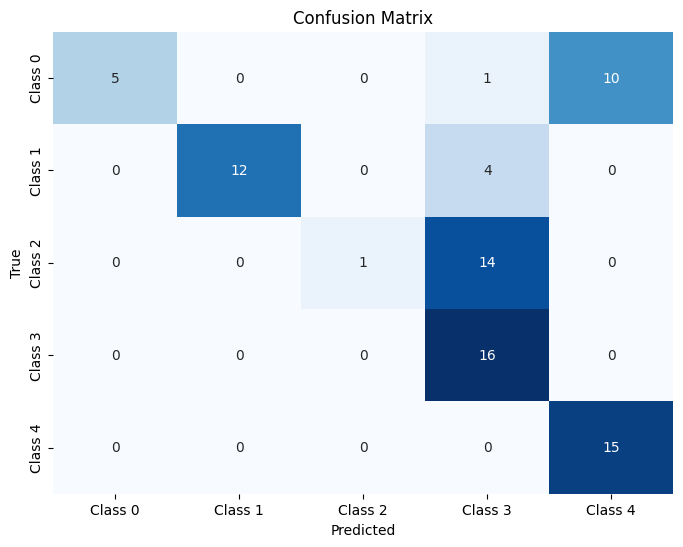

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


## MobileV2ViT

In [ ]:
model_name="MobileNetV2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


9406464/9406464 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_8[0][0]']             
 tional)                                                                                          
                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 366.04183983802795 seconds


3/3 [==============================] - 6s 499ms/step
Accuracy: 0.8974358974358975
Precision: 0.8978744703009409
Recall: 0.8974358974358975
F1 Score: 0.8969168885742858
AUC: 0.9876113671274961
Confusion Matrix:
 [[14  1  0  1  0]
 [ 1 15  0  0  0]
 [ 0  0 13  1  1]
 [ 2  0  1 13  0]
 [ 0  0  0  0 15]]
Testing Time taken: 6.07702898979187 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


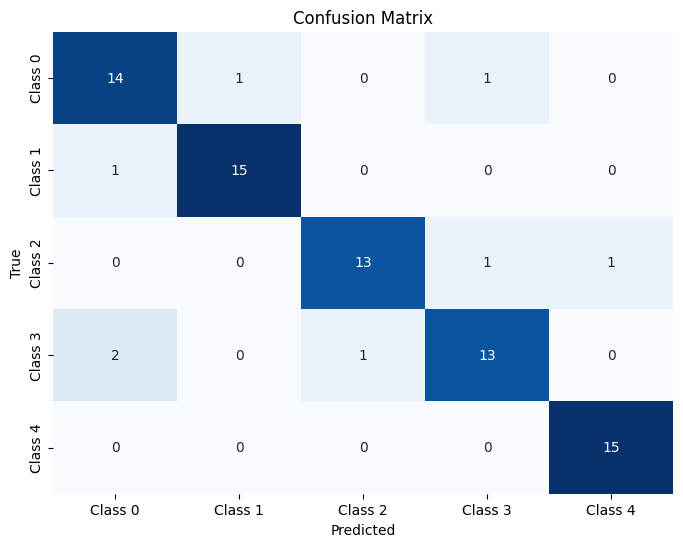

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration,durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'mobilev2_vit_model_architecture.png')


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/mobilev2_vit_model_architecture.png


## ResNet101-VIT

In [ ]:
model_name="ResNet101"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


171446536/171446536 [==============================] - 2s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_12[0][0]']            
                                                          6                                       
                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 551.3659417629242 seconds


3/3 [==============================] - 11s 2s/step
Accuracy: 0.8974358974358975
Precision: 0.9032023887793118
Recall: 0.8974358974358975
F1 Score: 0.8960872874862275
AUC: 0.9926316350913126
Confusion Matrix:
 [[12  1  0  1  2]
 [ 1 15  0  0  0]
 [ 0  1 13  1  0]
 [ 0  0  0 16  0]
 [ 0  1  0  0 14]]
Testing Time taken: 15.141170978546143 seconds


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


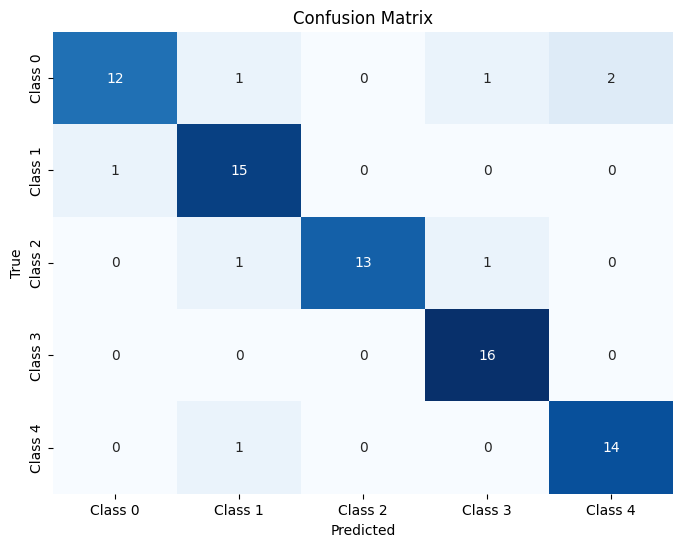

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'res101_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/res101_vit_model_architecture.png


## ResNet50

In [ ]:
del model

In [ ]:
model_name="ResNet50"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


94765736/94765736 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_16[0][0]']            
                                                          2                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_16[0][0]']            
                                                          2                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 395.61858773231506 seconds


3/3 [==============================] - 4s 164ms/step
Accuracy: 0.8846153846153846
Precision: 0.8960137028962939
Recall: 0.8846153846153846
F1 Score: 0.8830498364981124
AUC: 0.9924199948796723
Confusion Matrix:
 [[12  1  0  2  1]
 [ 0 16  0  0  0]
 [ 0  2 13  0  0]
 [ 0  0  0 16  0]
 [ 1  1  0  1 12]]
Testing Time taken: 4.4968767166137695 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


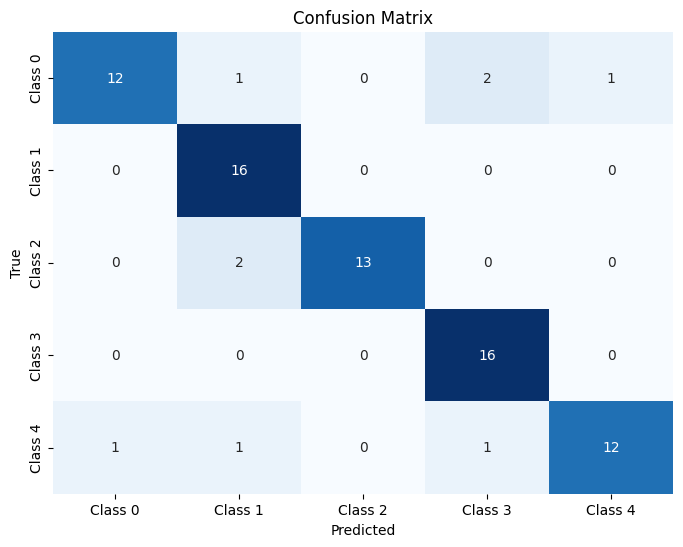

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'res50_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/res50_vit_model_architecture.png


## Hybrid ViT,ResNet50,MobileV3Small

In [ ]:
del model

In [ ]:
model_name="Res_Mob_ViT_best_arc"
save_model_dir = save_folder+model_name+'_extracted.h5'
model=createCombinedModel(img_size,num_classes)
visualize_model_architecture(model,filename=save_folder+'res50_mobv3_vit_model_architecture.png')
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

4334752/4334752 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/res50_mobv3_vit_model_architecture.png
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_20[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_20[0][0]']            
 al)                                                 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 489.19119691848755 seconds


3/3 [==============================] - 7s 681ms/step
Accuracy: 0.9358974358974359
Precision: 0.9435257402556164
Recall: 0.9358974358974359
F1 Score: 0.9350416793687094
AUC: 0.9965625533367468
Confusion Matrix:
 [[13  1  0  1  1]
 [ 0 16  0  0  0]
 [ 0  2 13  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 15]]
Testing Time taken: 7.5539209842681885 seconds


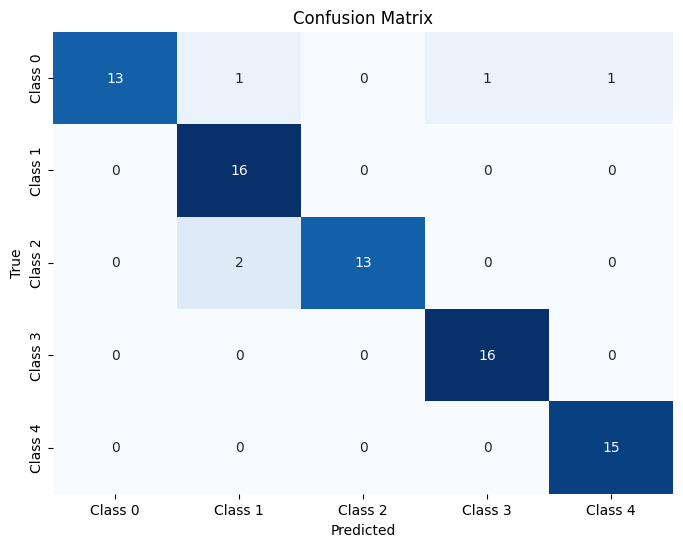

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [ ]:
# visualize_model_architecture(model,filename=save_folder+'res50_mobv3_vit_model_architecture.png')

## MobileNetV3Small

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Small"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_38[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_38[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1316.2517154216766 seconds


13/13 [==============================] - 12s 162ms/step
Accuracy: 0.6825
Precision: 0.6818177432751064
Recall: 0.6825
F1 Score: 0.6727092956522271
AUC: 0.9782828947368423
Confusion Matrix:
 [[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  3]
 [ 4  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  1  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  8  1  0  0  0  0  0]
 [ 0  0  0  0  1 12  0  0  0  0  0  0  0  0  6  1  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  1  0  0  0  0  4  0  0  0]
 [ 0  2  0  0  0  0  0  0  7  0  3  0  1  0  0  0  0  6  0  1]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  2  0  0  0  1  0  6  0]
 [ 0  0  0  0  0  0  0  1  1  0  9  0  0  0  0  0  0  3  0  6]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  7  0  1  0  3  0  0  0  0  

<ipython-input-15-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


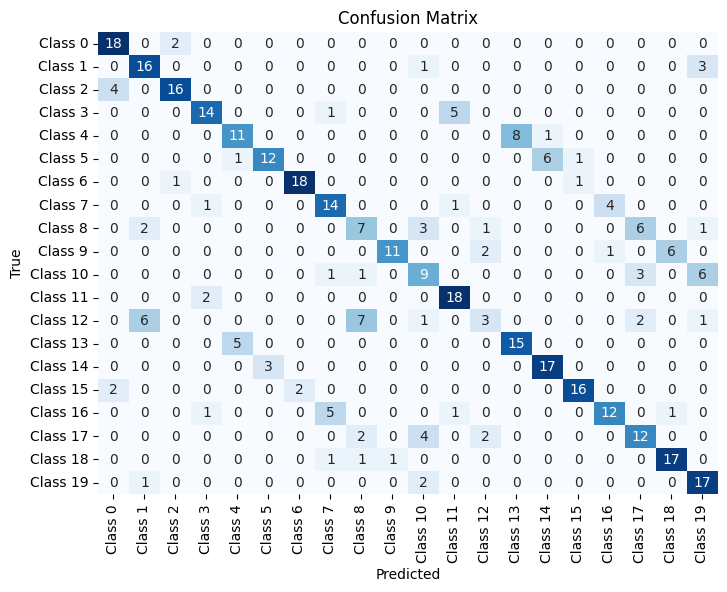

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'mobilev3s_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/mobilev3s_vit_model_architecture.png


#### test

In [ ]:
createTransferViTBatch

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Small"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
visualize_model_architecture(model,filename=save_folder+'mobilev3s_vit_model_architecture_batch.png')
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/mobilev3s_vit_model_architecture_batch.png
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_25[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_25[0][0]']            
 al)                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 343.7835068702698 seconds


3/3 [==============================] - 4s 104ms/step
Accuracy: 0.9487179487179487
Precision: 0.9494186777275013
Recall: 0.9487179487179487
F1 Score: 0.9482775906580135
AUC: 0.9963007765830346
Confusion Matrix:
 [[14  1  0  0  1]
 [ 1 15  0  0  0]
 [ 0  0 14  1  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 15]]
Testing Time taken: 4.628688335418701 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


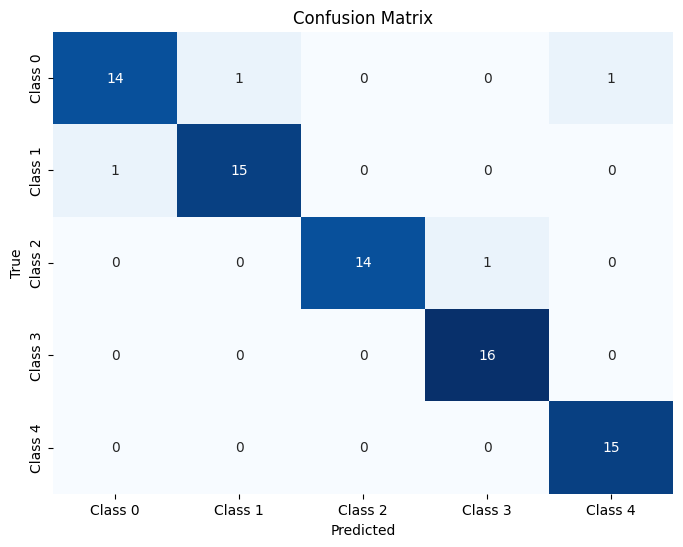

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

## Hybrid MobileV3Small,Dense201,ViT

In [ ]:
del model

In [ ]:
model_name="Den_Mob_ViT_best_arc"
save_model_dir = save_folder+model_name+'_extracted.h5'
model=createCombinedModel2(img_size,num_classes)
visualize_model_architecture(model,filename=save_folder+'dense201_mobv3_vit_model_architecture.png')
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

74836368/74836368 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/dense201_mobv3_vit_model_architecture.png
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_29[0][0]']            
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_29[0][0]']            
 al)                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 522.4083437919617 seconds


3/3 [==============================] - 22s 3s/step
Accuracy: 0.9230769230769231
Precision: 0.9348887631975867
Recall: 0.9230769230769231
F1 Score: 0.9215274845547798
AUC: 0.9950810718552654
Confusion Matrix:
 [[14  0  0  1  1]
 [ 0 16  0  0  0]
 [ 0  1 11  3  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 15]]
Testing Time taken: 22.599698781967163 seconds


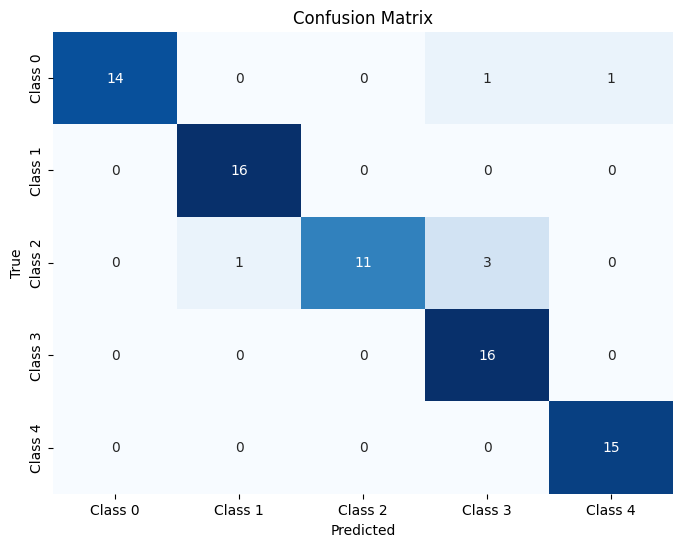

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

## MobileNetV3Large

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Large"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_4[0][0]']             
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 276.8776834011078 seconds


3/3 [==============================] - 7s 718ms/step
Accuracy: 0.8205128205128205
Precision: 0.8622710622710622
Recall: 0.8205128205128205
F1 Score: 0.827973841473206
AUC: 0.9781155060590544
Confusion Matrix:
 [[15  0  0  1  0]
 [ 3 13  0  0  0]
 [ 1  1 11  2  0]
 [ 4  0  0 12  0]
 [ 2  0  0  0 13]]
Testing Time taken: 6.8966145515441895 seconds


<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


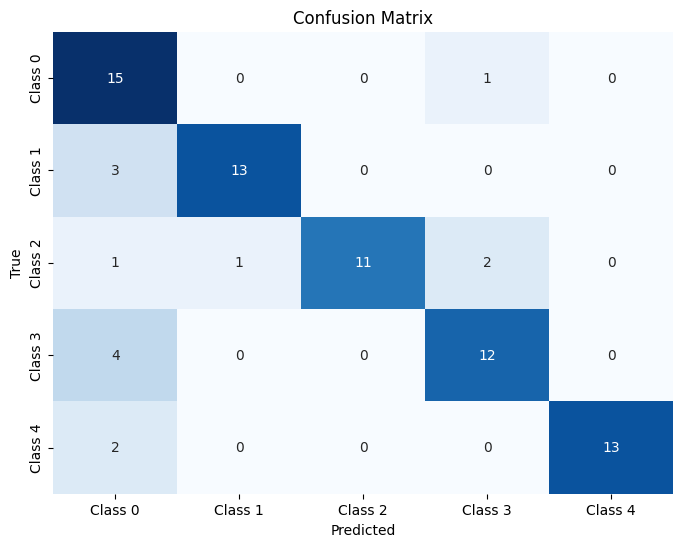

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'mobilev3l_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/mobilev3l_vit_model_architecture.png


## DenseNet201

In [ ]:
del model

In [ ]:
model_name="DenseNet201"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_8[0][0]']             
                                                          4                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 488.41704297065735 seconds


3/3 [==============================] - 20s 3s/step
Accuracy: 0.8974358974358975
Precision: 0.9003906098928726
Recall: 0.8974358974358975
F1 Score: 0.8970750944185479
AUC: 0.9839823348694317
Confusion Matrix:
 [[14  0  0  1  1]
 [ 1 15  0  0  0]
 [ 0  1 12  2  0]
 [ 0  0  1 15  0]
 [ 0  1  0  0 14]]
Testing Time taken: 20.594619750976562 seconds


<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


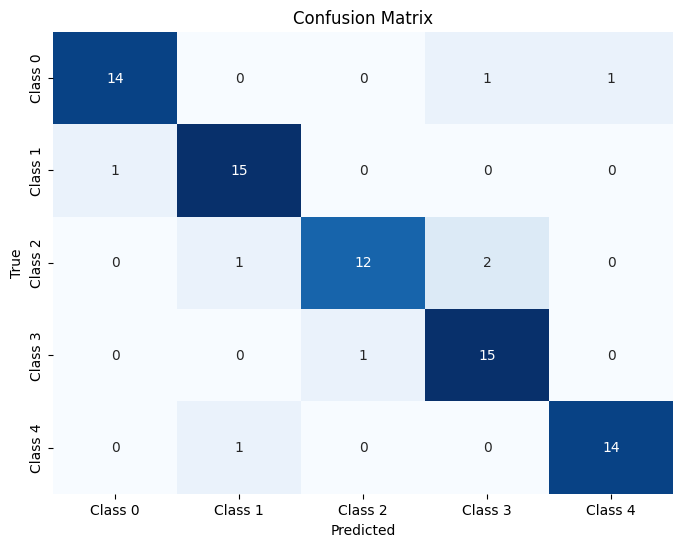

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'dense201_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/dense201_vit_model_architecture.png


## DenseNet121

In [ ]:
del model

In [ ]:
model_name="DenseNet121"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


29084464/29084464 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 densenet121 (Functional)    (None, 7, 7, 1024)           7037504   ['input_12[0][0]']            
                                                                                                  
 flatten_5 (Flatten)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 548.305412530899 seconds


3/3 [==============================] - 7s 424ms/step
Accuracy: 0.8846153846153846
Precision: 0.889171647066384
Recall: 0.8846153846153846
F1 Score: 0.8850167259510974
AUC: 0.9895171957671959
Confusion Matrix:
 [[14  0  0  1  1]
 [ 1 14  1  0  0]
 [ 0  1 12  2  0]
 [ 0  0  1 15  0]
 [ 0  0  0  1 14]]
Testing Time taken: 7.847636461257935 seconds


<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


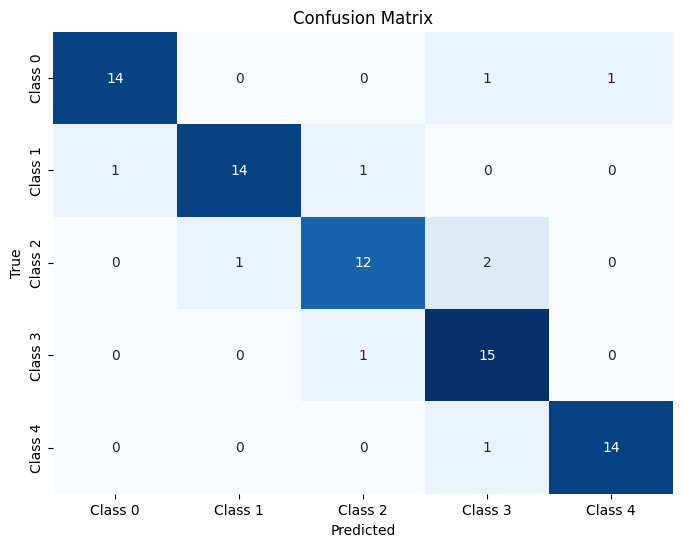

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'dense121_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/dense121_vit_model_architecture.png


## VGG16

In [ ]:
del model

In [ ]:
model_name="VGG16"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


58889256/58889256 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_16[0][0]']            
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_16[0][0]']            
                                                          8                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 448.0682566165924 seconds


3/3 [==============================] - 14s 2s/step
Accuracy: 0.8974358974358975
Precision: 0.9055910747980289
Recall: 0.8974358974358975
F1 Score: 0.8967530314513072
AUC: 0.9882763696876602
Confusion Matrix:
 [[12  3  0  0  1]
 [ 1 15  0  0  0]
 [ 0  1 13  1  0]
 [ 0  0  0 15  1]
 [ 0  0  0  0 15]]
Testing Time taken: 23.31574320793152 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/results.csv' successfully.


<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


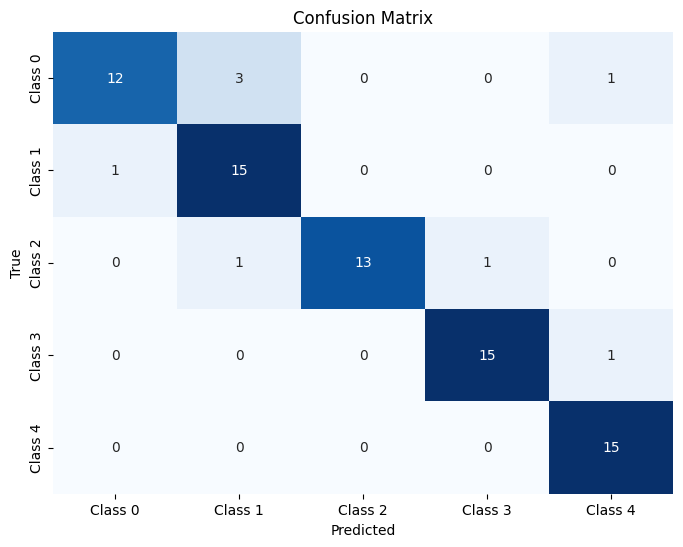

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'vgg16_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/vgg16_vit_model_architecture.png


# Cross Validation

## Functions

In [ ]:
def load_fold_indexes(foldNumber,path):
    try:
        train_indexes = np.load(f'{path}/fold{foldNumber}_train_indexes.npy')
        test_indexes = np.load(f'{path}/fold{foldNumber}_test_indexes.npy')

        return train_indexes,test_indexes
    except FileNotFoundError:
        print(f"Error: Files for fold {foldNumber} not found.")
        return None, None

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard,CSVLogger

def addCallbacks(fold):
  cllbks=[]
  # Define the callback
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',  # You can use 'val_accuracy' or other metrics
      factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
      patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
      min_lr=1e-6,          # Lower bound on the learning rate
      verbose=1
  )
  cllbks.append(reduce_lr)
  # Define the EarlyStopping callback
  early_stopping = EarlyStopping(
          monitor='val_loss',  # Metric to monitor (e.g., validation loss)
          patience=patience,          # Number of epochs with no improvement before stopping
          verbose=1,            # Verbosity level (1 for updates, 0 for silent)
          restore_best_weights=True  # Restore model weights to the best observed during training
          )
  cllbks.append(early_stopping)
  log_dir = save_folder+"Logs/"+model_name+"_"+str(fold)
  if not os.path.exists(log_dir):
        os.makedirs(log_dir)
  csv_logger_callback = CSVLogger(log_dir+'/logs.csv')
  cllbks.append(csv_logger_callback)
  # log_dir = save_folder+"Logs/"+model_name
  # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  # # cllbks.append(tensorboard_callback)
  return cllbks
# callbacks=addCallbacks()

In [ ]:
import pandas as pd

def append_to_csv_epochs(file_path, model_name,fold_number, accuracy, precision, recall, f1_score, testing_time, training_time,epochs):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        headers = ['Model Name','Fold Number', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time','Epochs']
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.DataFrame({'Model Name': [model_name],
                         'Fold Number': [fold_number],
                        'Accuracy': [accuracy],
                        'Precision': [precision],
                        'Recall': [recall],
                        'F1-Score': [f1_score],
                        'Testing Time': [testing_time],
                        'Training Time': [training_time],
                        'Epochs': [epochs]})

    # df=pd.concat(new_row, ignore_index=True)
    df = pd.concat([df, new_row], ignore_index=True)


    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)



# Jump

In [ ]:
def create_model_cv(img_size,num_classes,model_name,f):
  match model_name:
    case "vit":
      m=createModelBaseViT(img_size,num_classes)
    case "cnn_vit":
      m=createModelCNNViT(img_size,num_classes)

    case "Res_Mob_ViT_best_arc":
      m=createCombinedModel(img_size,num_classes)

    case "Den_Mob_ViT_best_arc":
      m=createCombinedModel2(img_size,num_classes)
    case _ :
      m=createTransferViT(img_size,num_classes,model_name)

      exit()
  c=addCallbacks(f)
  m.summary()
  return m,c

In [ ]:
def load_split_data(f,Oimages, Olabels,fold_path):
  train_indexes,test_indexes = load_fold_indexes(f,fold_path)
  if train_indexes is not None and test_indexes is not None:
    # Now you have the indexes for training and validation
    # You need to extract the actual data from your original data arrays
    all_X_train = Oimages[train_indexes]
    all_y_train = Olabels[train_indexes]
    X_test = Oimages[test_indexes]
    y_test = Olabels[test_indexes]
    X_train, X_val, y_train, y_val = train_test_split(all_X_train, all_y_train, test_size=0.2, random_state=42,stratify=all_y_train)
    y_train = encode_labels(y_train)
    y_test = encode_labels(y_test)
    y_val = encode_labels(y_val)
  return X_train,y_train,X_test,y_test,X_val,y_val

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_dic(confusion_matrix, class_label_mapping, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - class_label_mapping (dict): Mapping of class indices to class labels.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 8))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[class_label_mapping[i] for i in range(1, confusion_matrix.shape[0] + 1)],
                yticklabels=[class_label_mapping[i] for i in range(1, confusion_matrix.shape[1] + 1)])

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, class_label_mapping, save_path='confusion_matrix_heatmap_extracted.png')


In [ ]:
import cv2
import numpy as np

def resize_images_cv2(image_array,wdith,height):
    """
    Resize each image in the input numpy array to 224x224 pixels using cv2.

    Parameters:
    - image_array (numpy.ndarray): Input array of images.

    Returns:
    - resized_images (numpy.ndarray): Array of resized images.
    """
    resized_images = []

    for image in image_array:
        # Resize the image to 224x224 pixels using cv2
        resized_image = cv2.resize(image, (wdith,height))

        resized_images.append(resized_image)

    return np.array(resized_images)

# Example usage:
# Assuming you have a numpy array named 'original_images' containing your images
# resized_images = resize_images_cv2(original_images)

## Paramters

In [ ]:
# create top 6 models
model_names=['DenseNet201','ResNet101',
             'VGG16','vit',
             'Res_Mob_ViT_best_arc','MobileNetV3Large']
class_label_mapping = {
    1: 'Lifting of the arms',
    2: 'Lateral tilt of the trunk with the arms in extension',
    3: 'Trunk rotation',
    4: 'Pelvis rotations on the transverse plane',
    5: 'Squatting'
}

In [ ]:
batch_size = 64
num_classes = 5  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=30
img_size=(width, height, 3)
num_folds=5
fold_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/folds'
save_folder=save_folder+'cv/'
csv_file_path=save_folder+"results_cv.csv"
# create_empty_csv_file(save_folder+"results.csv")

## Load & Process

In [ ]:
from sklearn.preprocessing import LabelEncoder

#load data
Oimages, Olabels = load_images_and_labels_f(dataset_path)
# Convert labels from string to numbers
label_encoder = LabelEncoder()
Olabels_numeric = label_encoder.fit_transform(Olabels)


Loading Images: 100%|██████████| 386/386 [00:05<00:00, 70.10it/s]


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder

# # Convert labels from string to numbers
# label_encoder = LabelEncoder()
# Olabels_numeric = label_encoder.fit_transform(Olabels)


# ## Save indexes
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
# for fold, (train_index, test_index) in enumerate(skf.split(Oimages, Olabels)):
#     print(f"Processing fold {fold + 1}/{num_folds}")
#     # Models,Names,Callbacks=create_and_initialize_models(no_classes, no_features, base_url)

#     all_X_train, X_test = Oimages[train_index], Oimages[test_index]
#     all_y_train, y_test = Olabels_numeric[train_index], Olabels_numeric[test_index]


#     # Save the train and validation indexes to separate files
#     np.save(f'fold{fold + 1}_train_indexes.npy', train_index)
#     np.save(f'fold{fold + 1}_test_indexes.npy', test_index)


In [ ]:
Oimages = resize_images_cv2(Oimages,width, height)
Oimages[0].shape

(224, 224, 3)

## Fold 1

Processing Model 1 of 6 : DenseNet201


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 22s 3s/step
Accuracy: 0.9358974358974359
Precision: 0.9407051282051282
Recall: 0.9358974358974359
F1 Score: 0.936313086028456
AUC: 0.9939210887518917
Confusion Matrix:
 [[16  1  0  0  1]
 [ 0 19  0  0  1]
 [ 0  0 10  1  0]
 [ 0  0  0 14  0]
 [ 0  0  0  1 14]]
Testing Time taken: 22.148712158203125 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 6 : ResNet101


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_8[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 884ms/step
Accuracy: 0.9358974358974359
Precision: 0.942918192918193
Recall: 0.9358974358974359
F1 Score: 0.9357485333095088
AUC: 0.9950151660280971
Confusion Matrix:
 [[15  1  0  0  2]
 [ 0 20  0  0  0]
 [ 0  0 10  1  0]
 [ 0  0  0 13  1]
 [ 0  0  0  0 15]]
Testing Time taken: 9.754433155059814 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 3 of 6 : VGG16


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_12[0][0]']            
                                                          8                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 14s 2s/step
Accuracy: 0.9487179487179487
Precision: 0.9557387057387058
Recall: 0.9487179487179487
F1 Score: 0.9486368795311885
AUC: 0.9962044449005656
Confusion Matrix:
 [[15  1  0  0  2]
 [ 0 20  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 13  1]
 [ 0  0  0  0 15]]
Testing Time taken: 13.626920223236084 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 4 of 6 : vit


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 352)               270688    
                                                                 
 dropout_12 (Dropout)        (None, 352)               0         
                                                                 
 dense_16 (Dense)            (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 4s 123ms/step
Accuracy: 0.9615384615384616
Precision: 0.9665551839464884
Recall: 0.9615384615384616
F1 Score: 0.9618885783956463
AUC: 0.9992467729428937
Confusion Matrix:
 [[16  2  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 11  0  0]
 [ 0  1  0 13  0]
 [ 0  0  0  0 15]]
Testing Time taken: 4.174715518951416 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 5 of 6 : Res_Mob_ViT_best_arc


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_18[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_18[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 677ms/step
Accuracy: 0.9615384615384616
Precision: 0.9651655534008475
Recall: 0.9615384615384616
F1 Score: 0.9614366931888452
AUC: 0.99826673964605
Confusion Matrix:
 [[16  0  0  0  2]
 [ 0 20  0  0  0]
 [ 0  1 10  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 15]]
Testing Time taken: 8.73831057548523 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 6 of 6 : MobileNetV3Large


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_22[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_22[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 626ms/step
Accuracy: 0.9615384615384616
Precision: 0.9638049450549451
Recall: 0.9615384615384616
F1 Score: 0.9610632369269018
AUC: 0.9982320607460533
Confusion Matrix:
 [[16  1  0  0  1]
 [ 0 20  0  0  0]
 [ 0  0 10  1  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 15]]
Testing Time taken: 8.88585877418518 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.


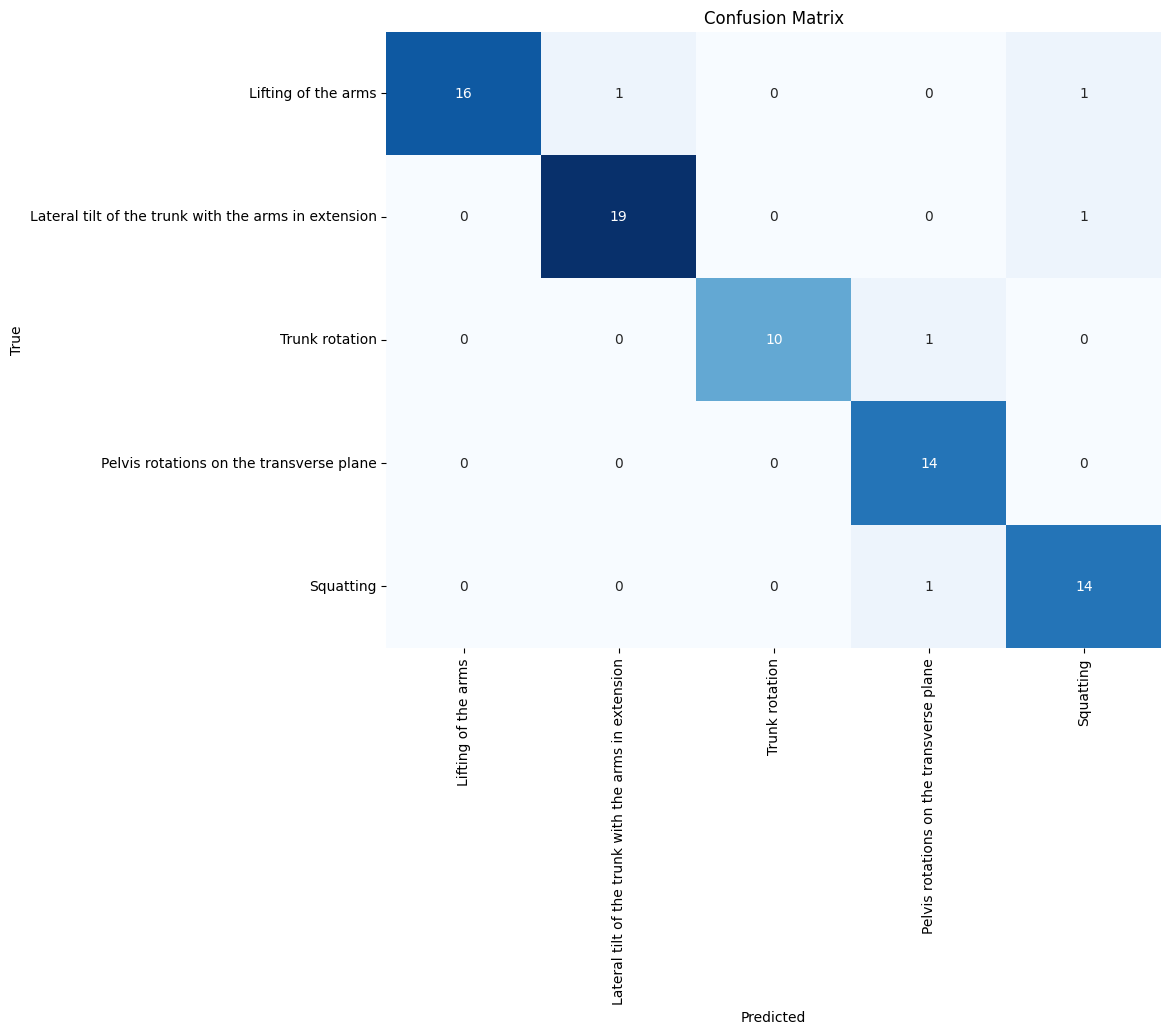

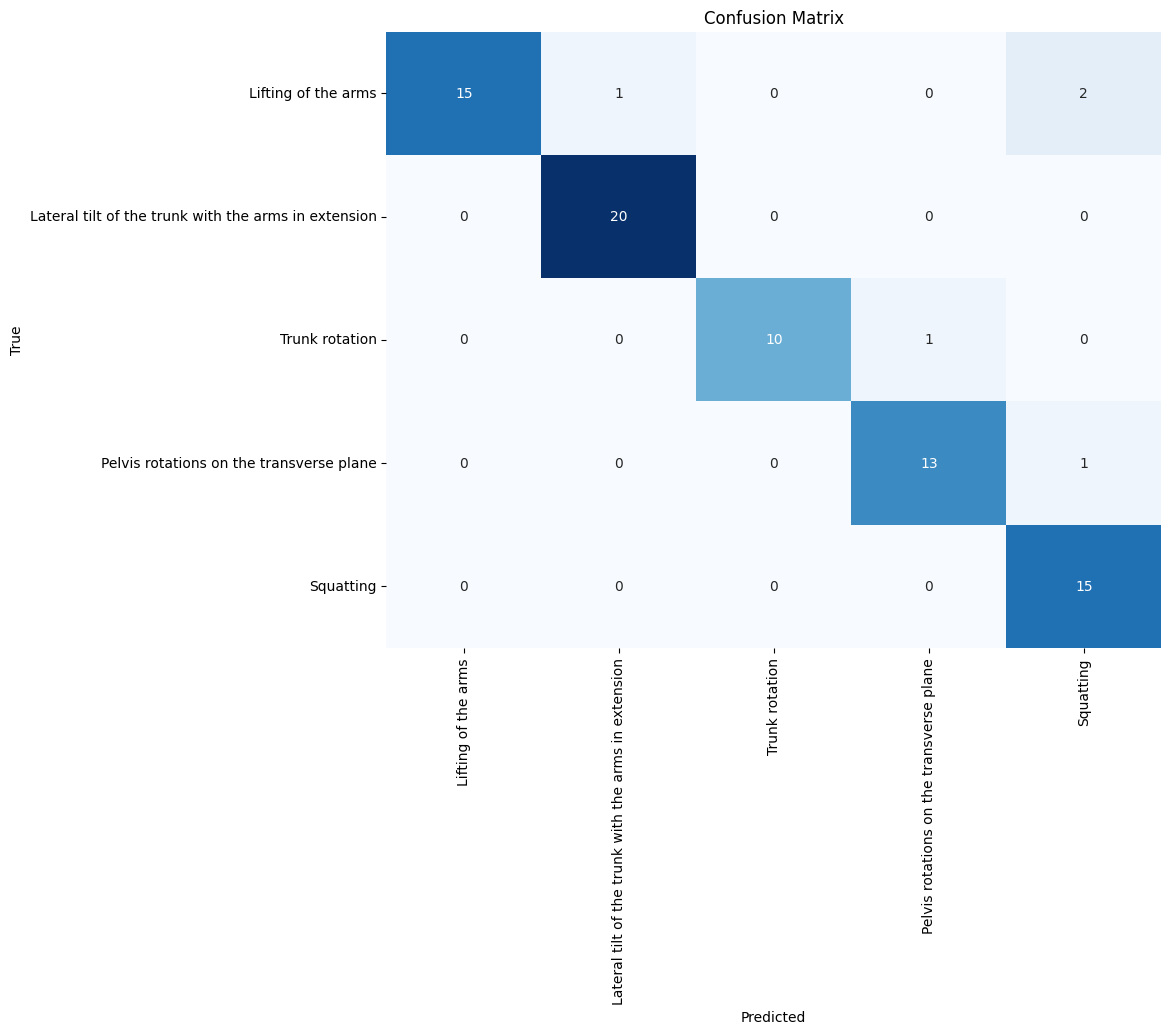

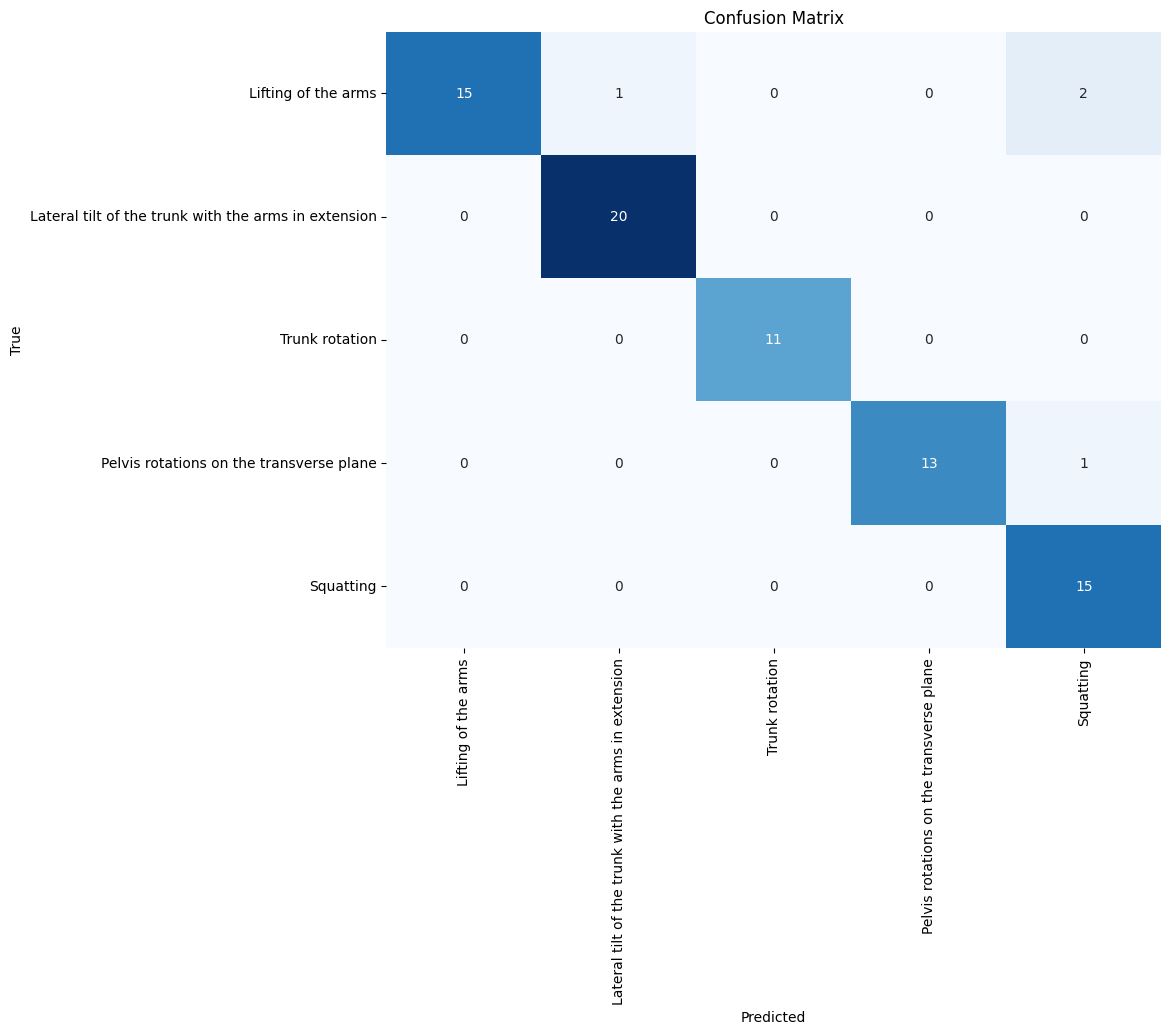

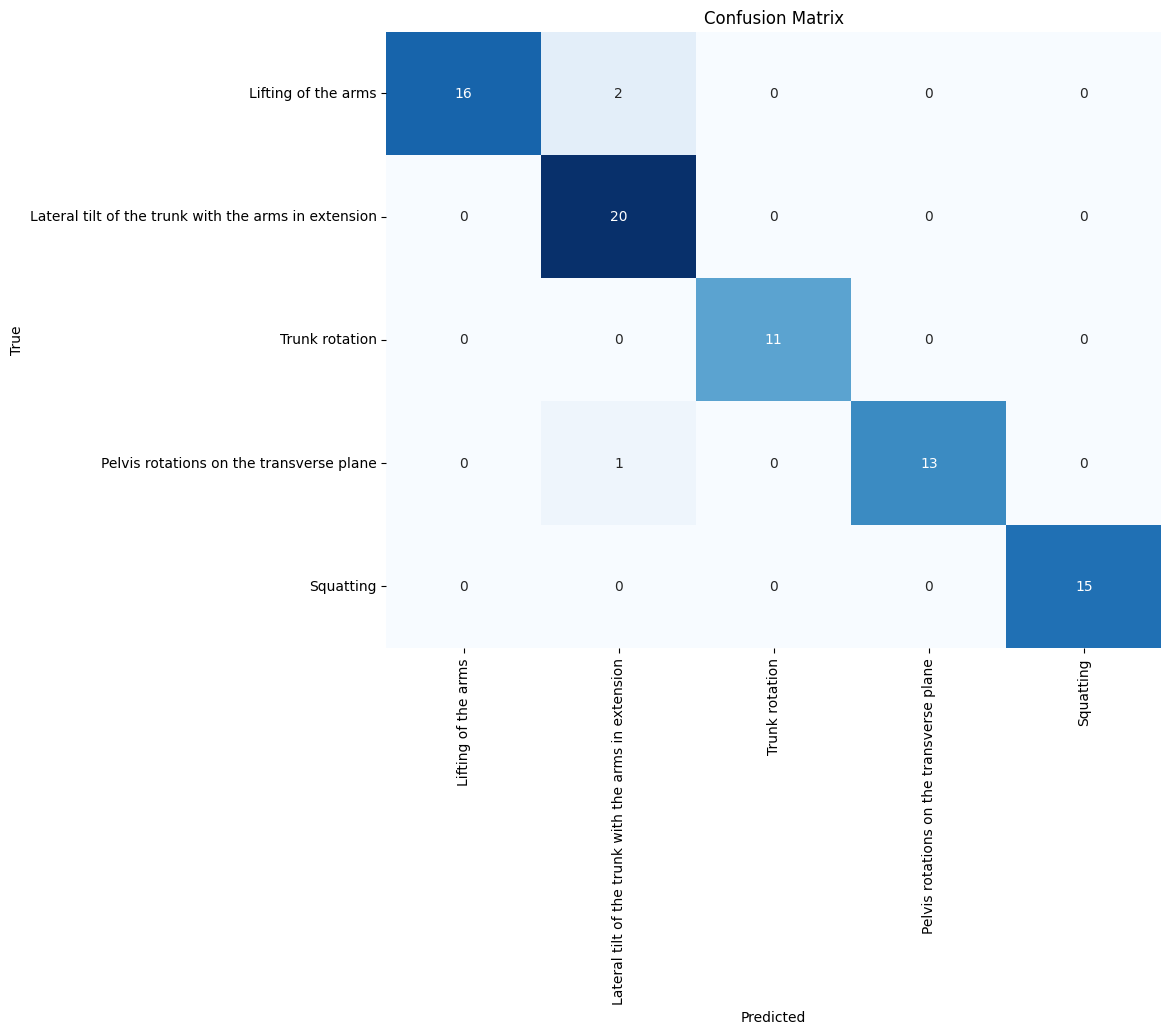

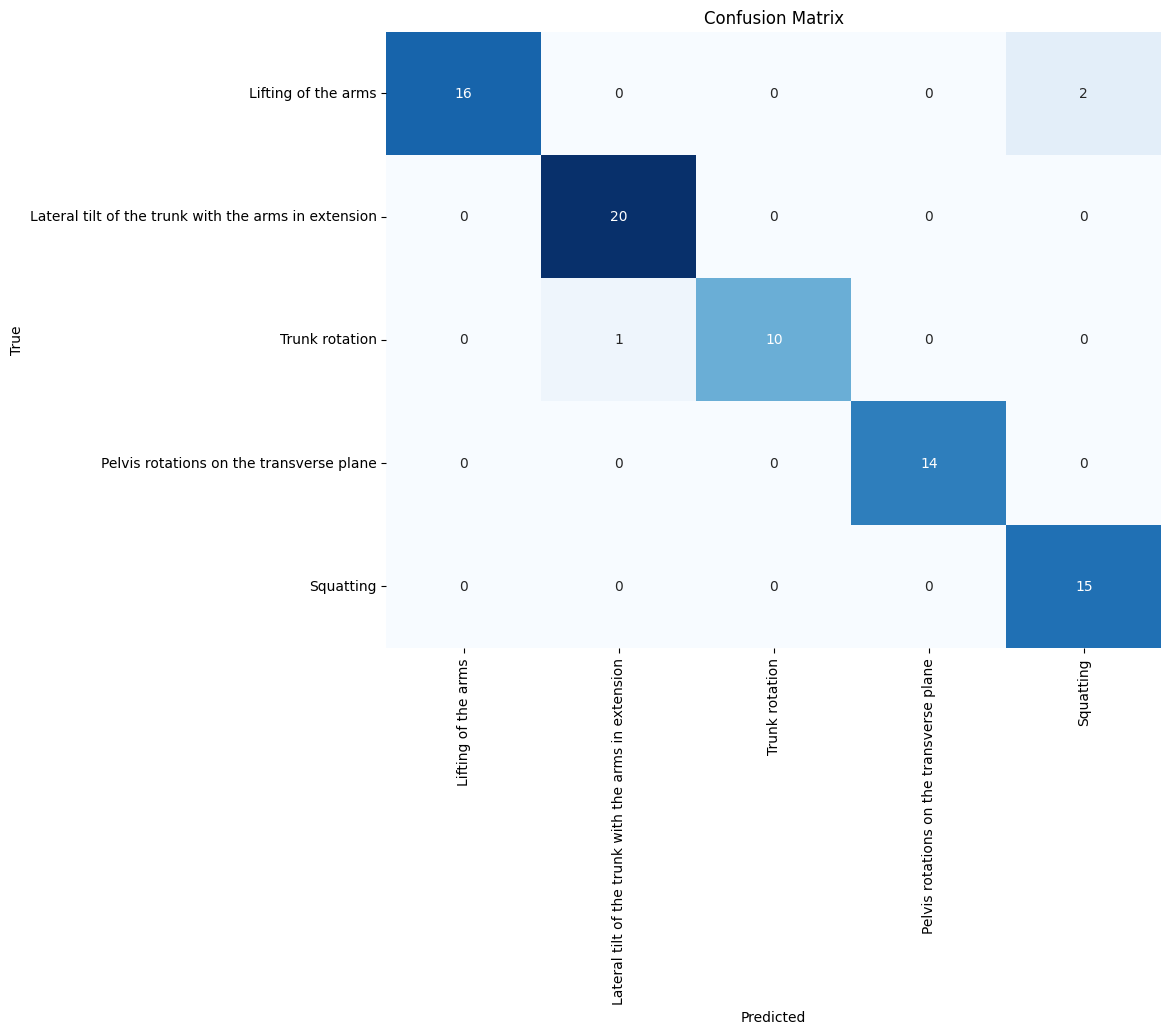

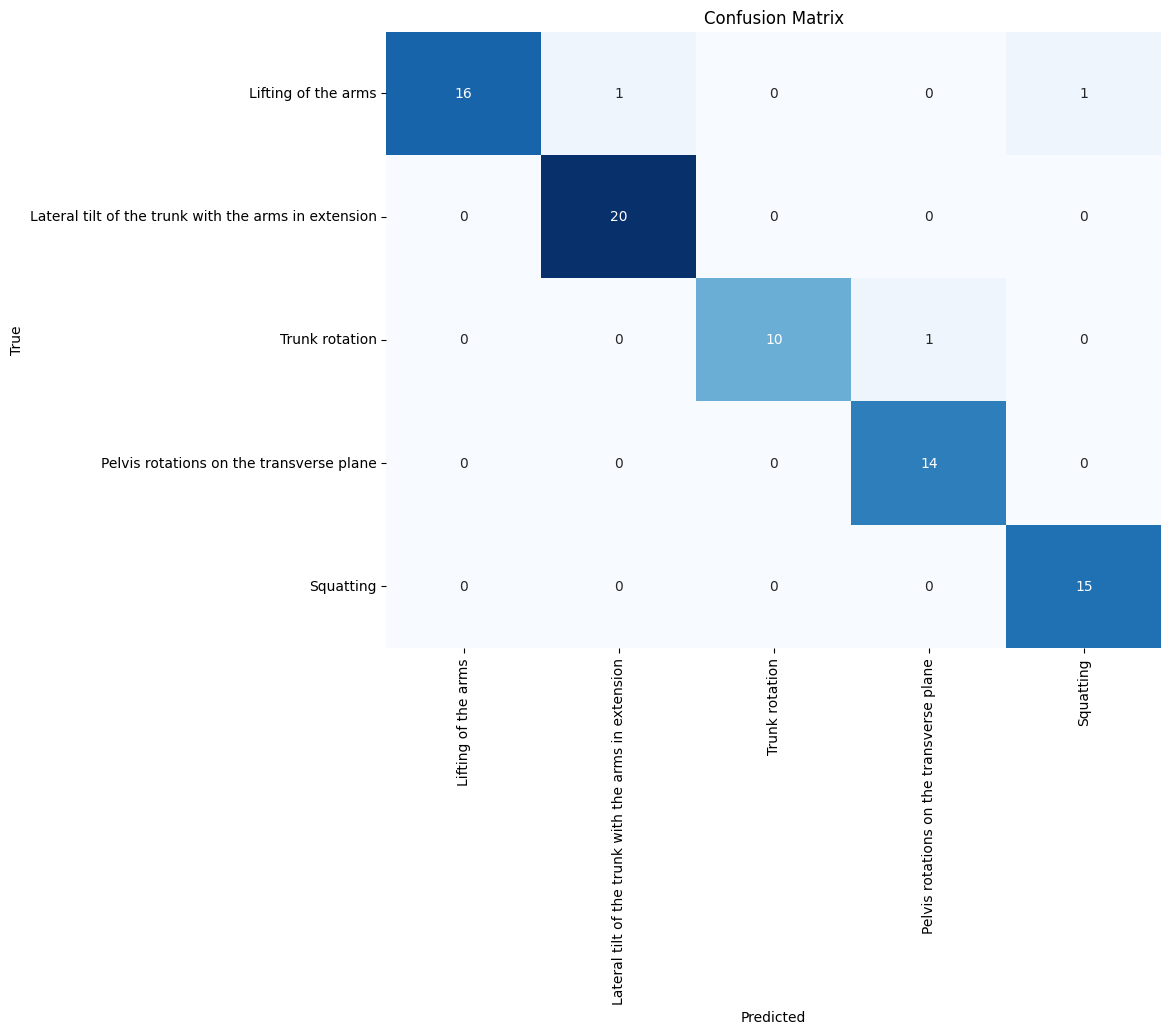

In [ ]:
fold_number = 1
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 2

Processing Model 1 of 6 : DenseNet201


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 20s 3s/step
Accuracy: 0.948051948051948
Precision: 0.9526433162796799
Recall: 0.948051948051948
F1 Score: 0.9484448638709012
AUC: 0.9954237974531657
Confusion Matrix:
 [[10  0  0  0  1]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  1  0 16  0]
 [ 0  2  0  0 17]]
Testing Time taken: 27.102887392044067 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 6 : ResNet101


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_8[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 8s 841ms/step
Accuracy: 0.8961038961038961
Precision: 0.9090852870073649
Recall: 0.8961038961038961
F1 Score: 0.8960300639102646
AUC: 0.9869017602091159
Confusion Matrix:
 [[10  1  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 1  0  0 15  1]
 [ 3  2  0  0 14]]
Testing Time taken: 8.328907489776611 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 3 of 6 : VGG16


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_12[0][0]']            
                                                          8                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 13s 2s/step
Accuracy: 0.922077922077922
Precision: 0.9290921638747727
Recall: 0.922077922077922
F1 Score: 0.9225915070070914
AUC: 0.9969017013894097
Confusion Matrix:
 [[ 9  1  0  0  1]
 [ 0 19  0  0  0]
 [ 0  1 10  0  0]
 [ 0  1  0 16  0]
 [ 1  1  0  0 17]]
Testing Time taken: 13.225335359573364 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 4 of 6 : vit


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 352)               270688    
                                                                 
 dropout_12 (Dropout)        (None, 352)               0         
                                                                 
 dense_16 (Dense)            (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 3s 99ms/step
Accuracy: 0.974025974025974
Precision: 0.974025974025974
Recall: 0.974025974025974
F1 Score: 0.974025974025974
AUC: 0.9944028638138521
Confusion Matrix:
 [[10  0  0  0  1]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 17  0]
 [ 1  0  0  0 18]]
Testing Time taken: 3.1905620098114014 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 5 of 6 : Res_Mob_ViT_best_arc


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_18[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_18[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 8s 738ms/step
Accuracy: 0.935064935064935
Precision: 0.9386209029066171
Recall: 0.935064935064935
F1 Score: 0.9343268532709528
AUC: 0.9968660213556708
Confusion Matrix:
 [[10  1  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  1 16  0]
 [ 1  1  0  1 16]]
Testing Time taken: 10.015277862548828 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 6 of 6 : MobileNetV3Large


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_22[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_22[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 529ms/step
Accuracy: 0.922077922077922
Precision: 0.9332768680594768
Recall: 0.922077922077922
F1 Score: 0.9221460772595059
AUC: 0.9946848454850434
Confusion Matrix:
 [[10  1  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  1  0 16  0]
 [ 2  2  0  0 15]]
Testing Time taken: 5.849313259124756 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.


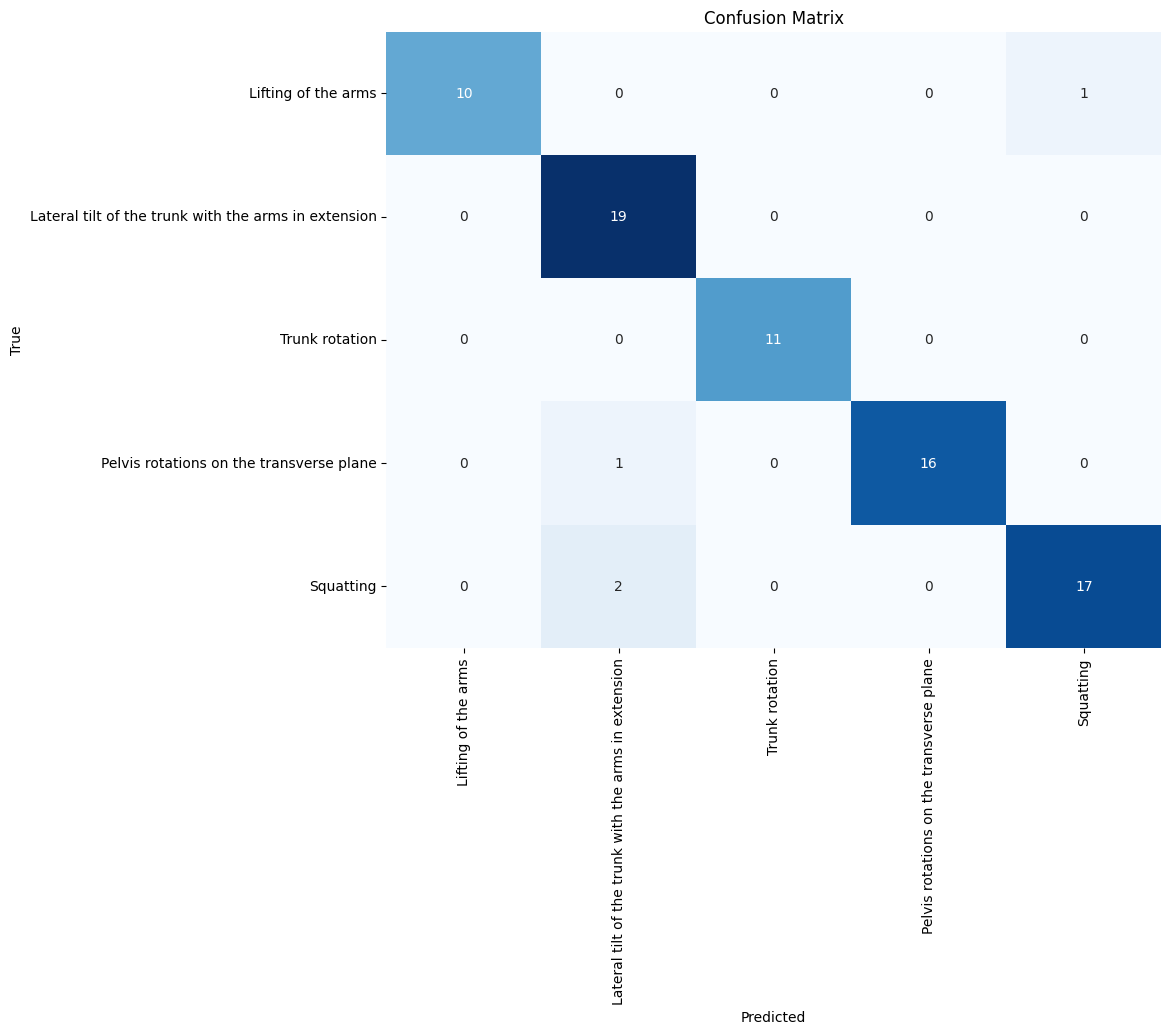

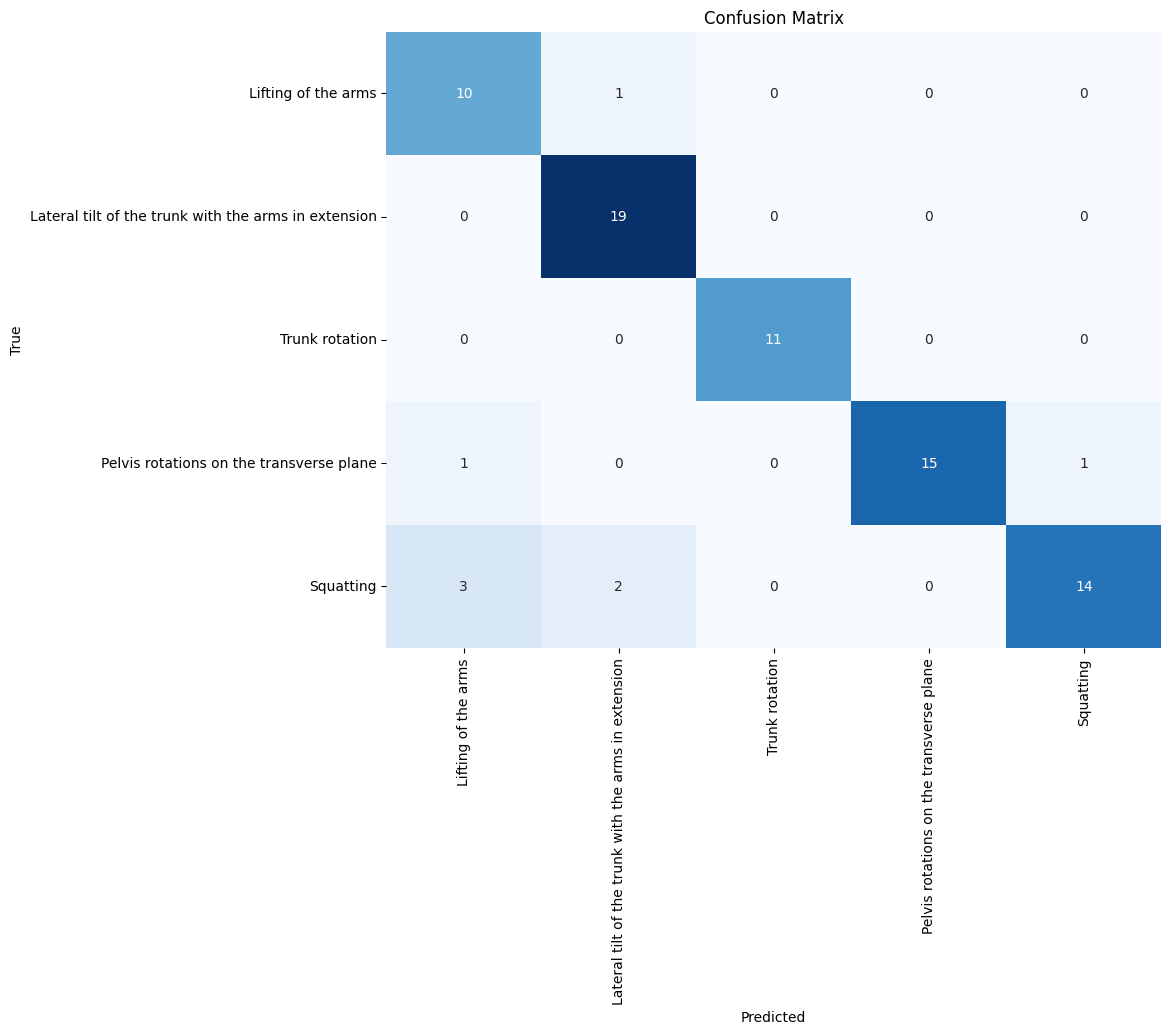

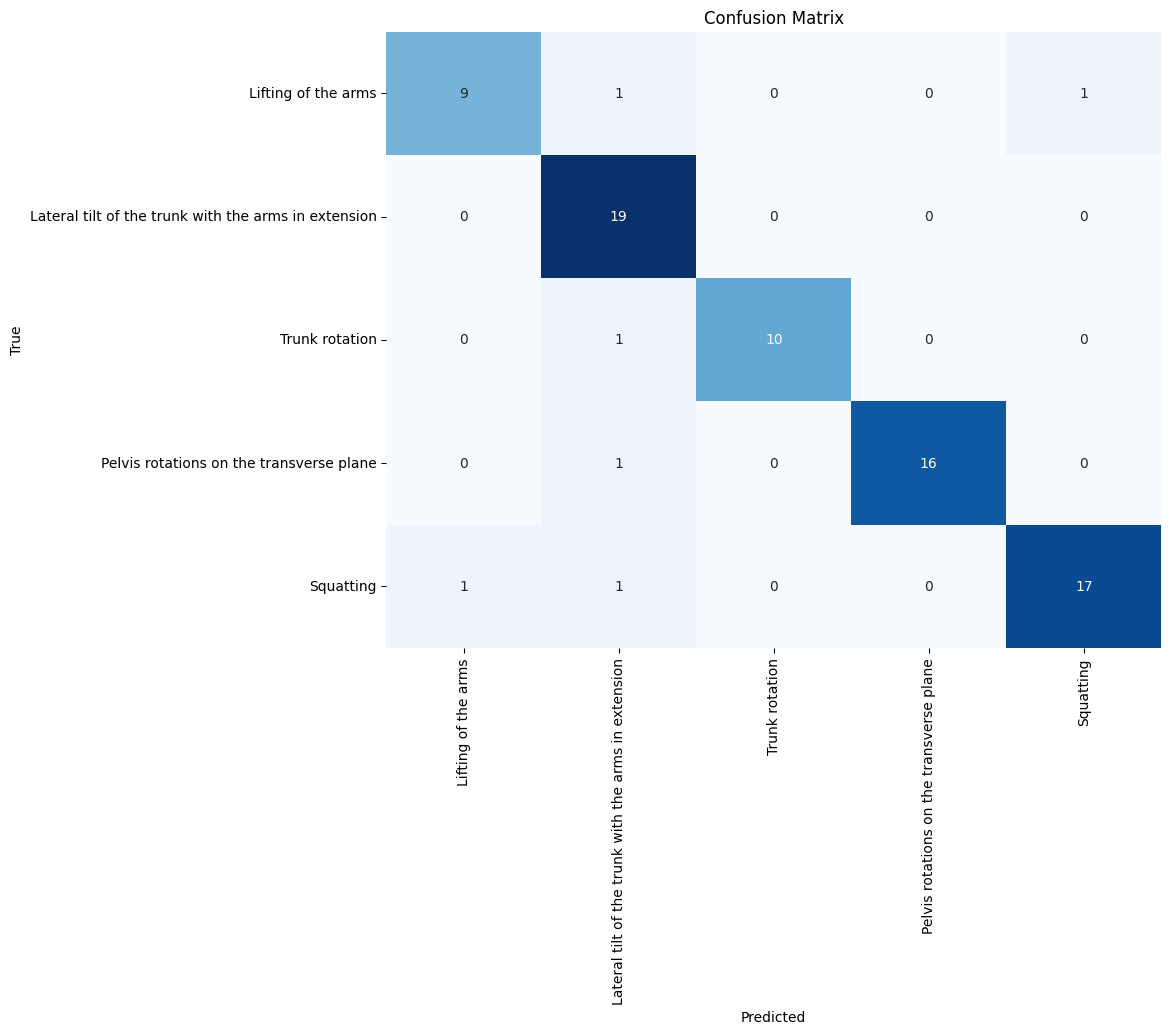

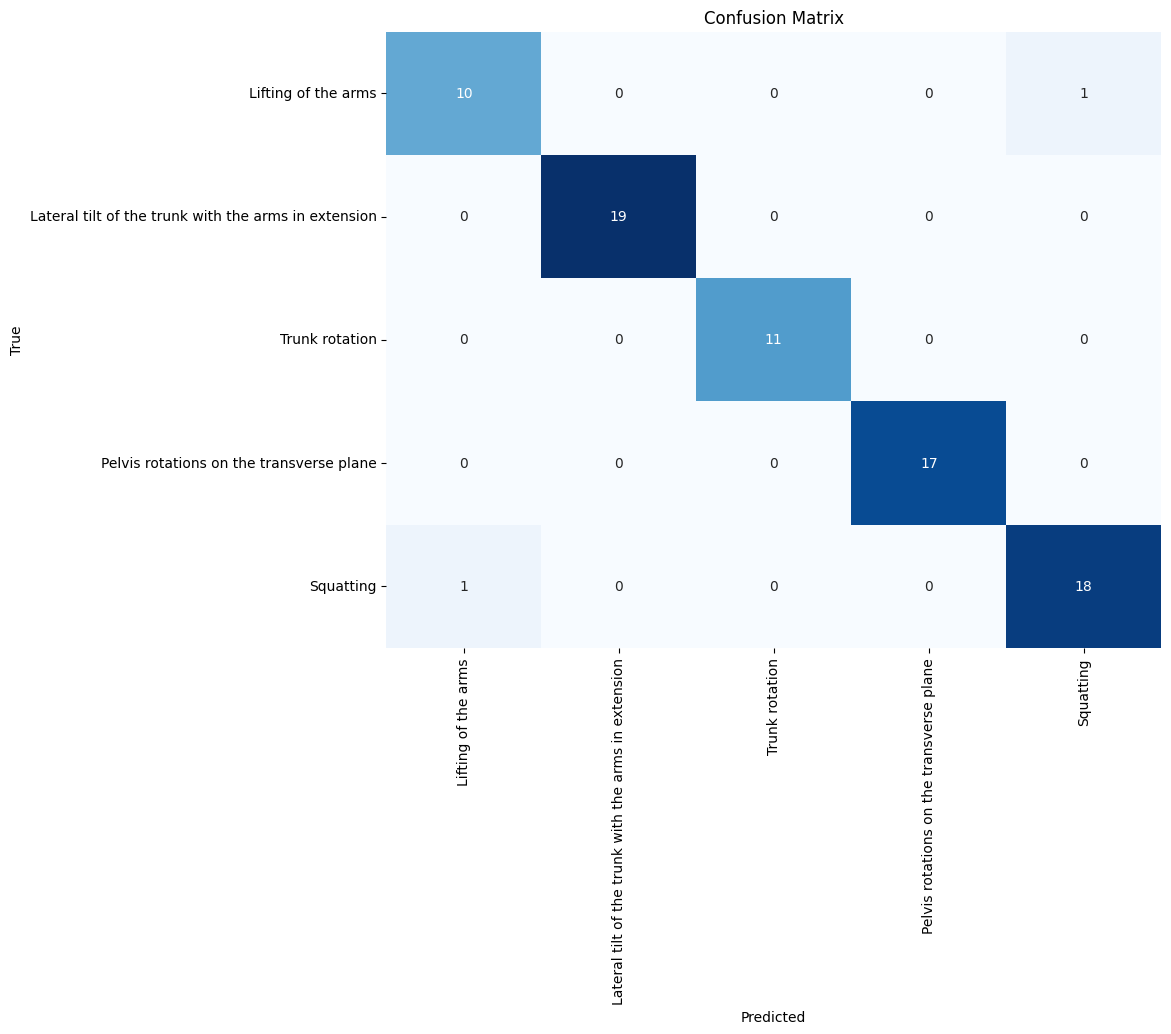

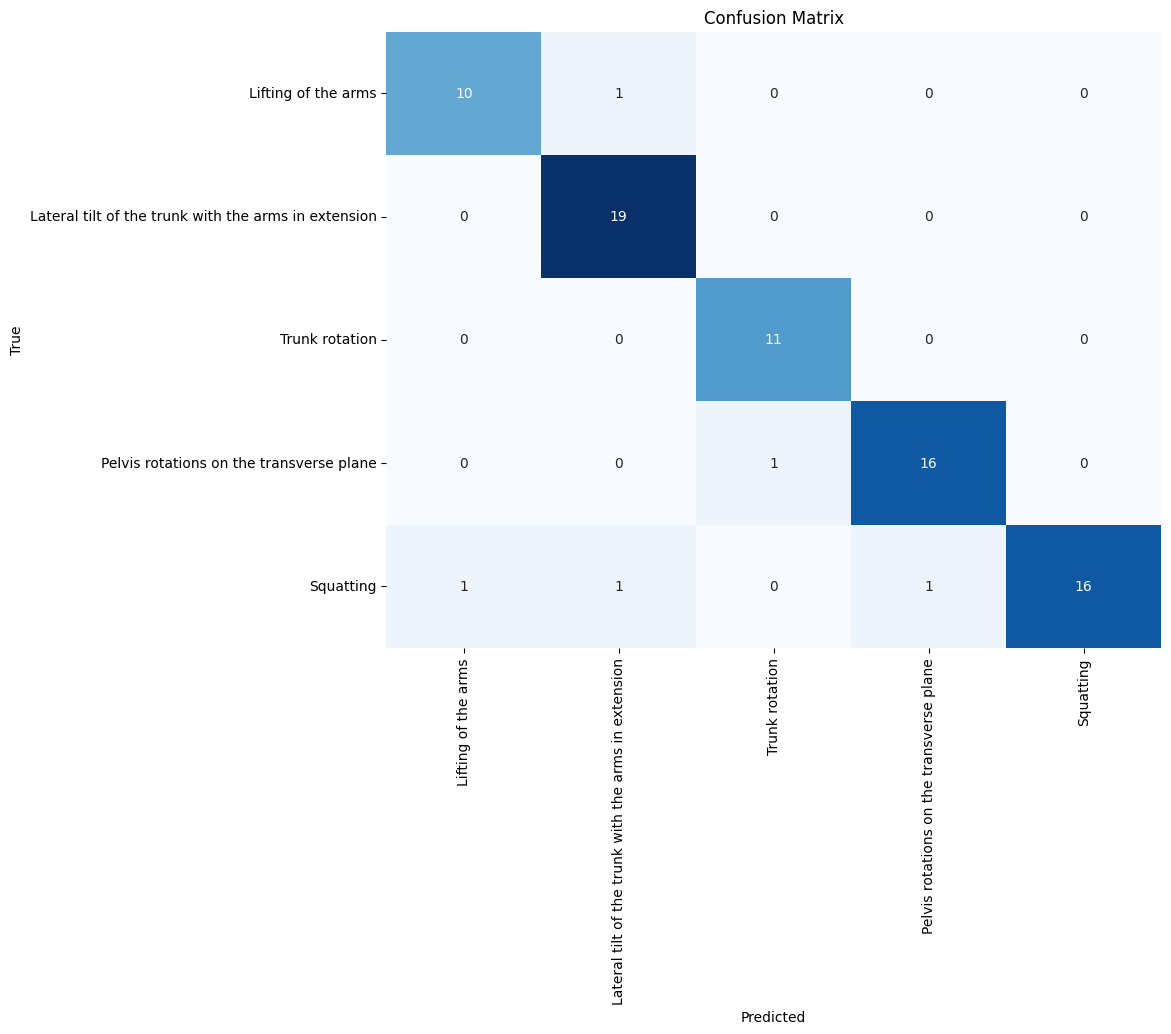

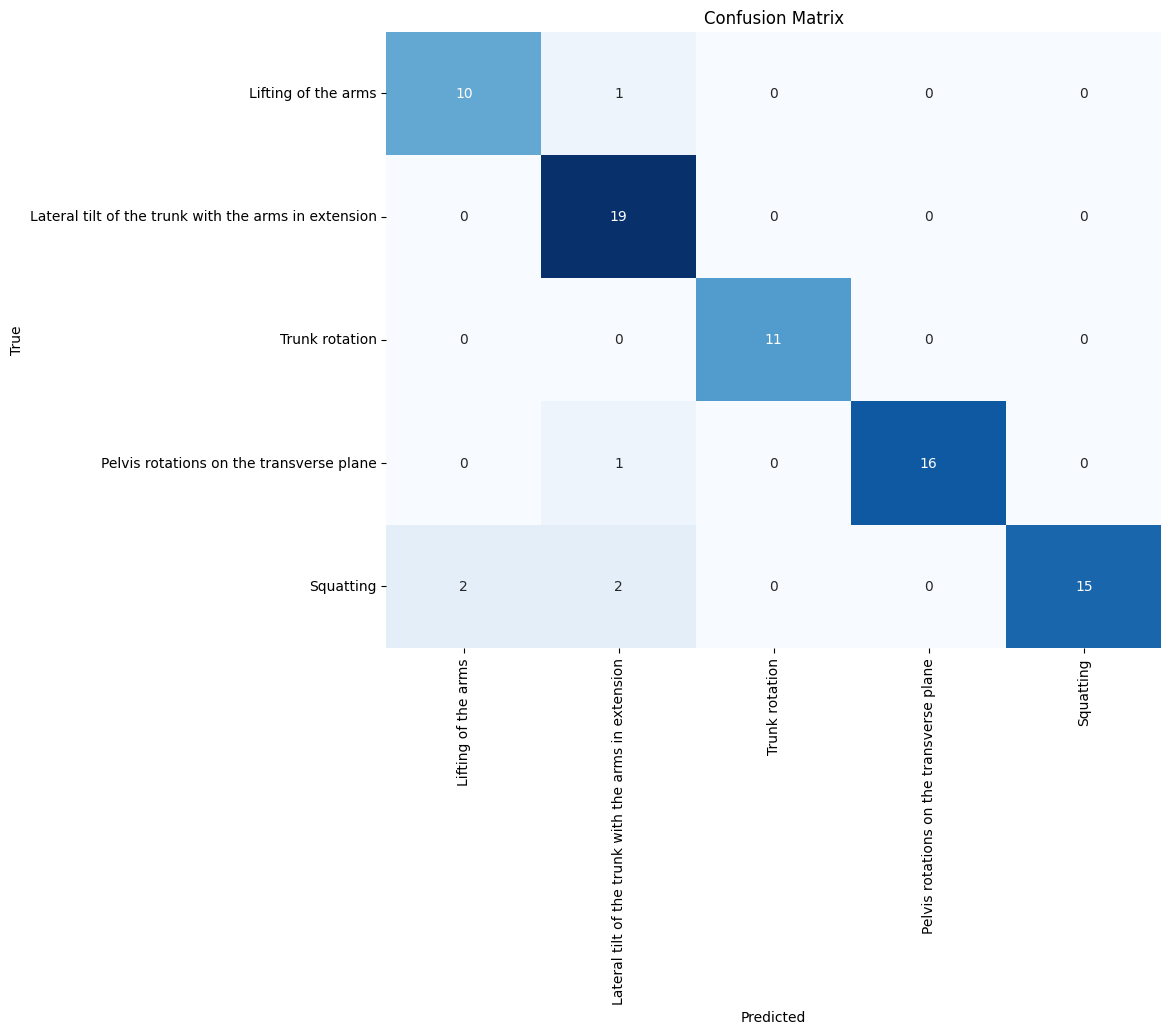

In [ ]:
fold_number = 2
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 3

Processing Model 1 of 6 : DenseNet201
353253686/353253686 [==============================] - 8s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


74836368/74836368 [==============================] - 3s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 21s 3s/step
Accuracy: 0.8831168831168831
Precision: 0.8856560106560106
Recall: 0.8831168831168831
F1 Score: 0.8836159690436447
AUC: 0.9924315085428876
Confusion Matrix:
 [[14  0  0  0  2]
 [ 0 14  0  1  0]
 [ 0  0 11  1  0]
 [ 0  0  2 14  1]
 [ 2  0  0  0 15]]
Testing Time taken: 21.186001300811768 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 6 : ResNet101


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


171446536/171446536 [==============================] - 5s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_8[0][0]']             
                                                          6                                       
                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 849ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.38961038961038963
Precision: 0.15708101422387136
Recall: 0.38961038961038963
F1 Score: 0.2237348858038513
AUC: 0.9191012998780442
Confusion Matrix:
 [[16  0  0  0  0]
 [ 1 14  0  0  0]
 [ 0 12  0  0  0]
 [10  7  0  0  0]
 [15  2  0  0  0]]
Testing Time taken: 10.124722242355347 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 3 of 6 : VGG16


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


58889256/58889256 [==============================] - 2s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_12[0][0]']            
                                                          8                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 14s 2s/step
Accuracy: 0.948051948051948
Precision: 0.9494949494949495
Recall: 0.948051948051948
F1 Score: 0.9483262079535372
AUC: 0.9967582152659299
Confusion Matrix:
 [[15  0  0  1  0]
 [ 0 15  0  0  0]
 [ 0  0 11  1  0]
 [ 0  0  0 16  1]
 [ 1  0  0  0 16]]
Testing Time taken: 23.46849536895752 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 4 of 6 : vit


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 352)               270688    
                                                                 
 dropout_12 (Dropout)        (None, 352)               0         
                                                                 
 dense_16 (Dense)            (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 3s 102ms/step
Accuracy: 0.961038961038961
Precision: 0.9637730690362271
Recall: 0.961038961038961
F1 Score: 0.9613397748193986
AUC: 0.999795081967213
Confusion Matrix:
 [[15  0  0  1  0]
 [ 0 14  0  1  0]
 [ 0  0 12  0  0]
 [ 0  0  0 17  0]
 [ 1  0  0  0 16]]
Testing Time taken: 3.1540236473083496 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 5 of 6 : Res_Mob_ViT_best_arc
4334752/4334752 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_18[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_18[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 8s 725ms/step
Accuracy: 0.961038961038961
Precision: 0.9611721611721611
Recall: 0.961038961038961
F1 Score: 0.960670297444491
AUC: 0.9987970106075217
Confusion Matrix:
 [[14  0  1  0  1]
 [ 0 15  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 17  0]
 [ 1  0  0  0 16]]
Testing Time taken: 8.436445713043213 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 6 of 6 : MobileNetV3Large


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_22[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_22[0][0]']            
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 7s 543ms/step
Accuracy: 0.9090909090909091
Precision: 0.9152056277056276
Recall: 0.9090909090909091
F1 Score: 0.910280775080047
AUC: 0.9905654453539949
Confusion Matrix:
 [[14  0  0  1  1]
 [ 0 14  0  1  0]
 [ 0  0 11  1  0]
 [ 0  0  1 16  0]
 [ 1  0  0  1 15]]
Testing Time taken: 7.207010269165039 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.


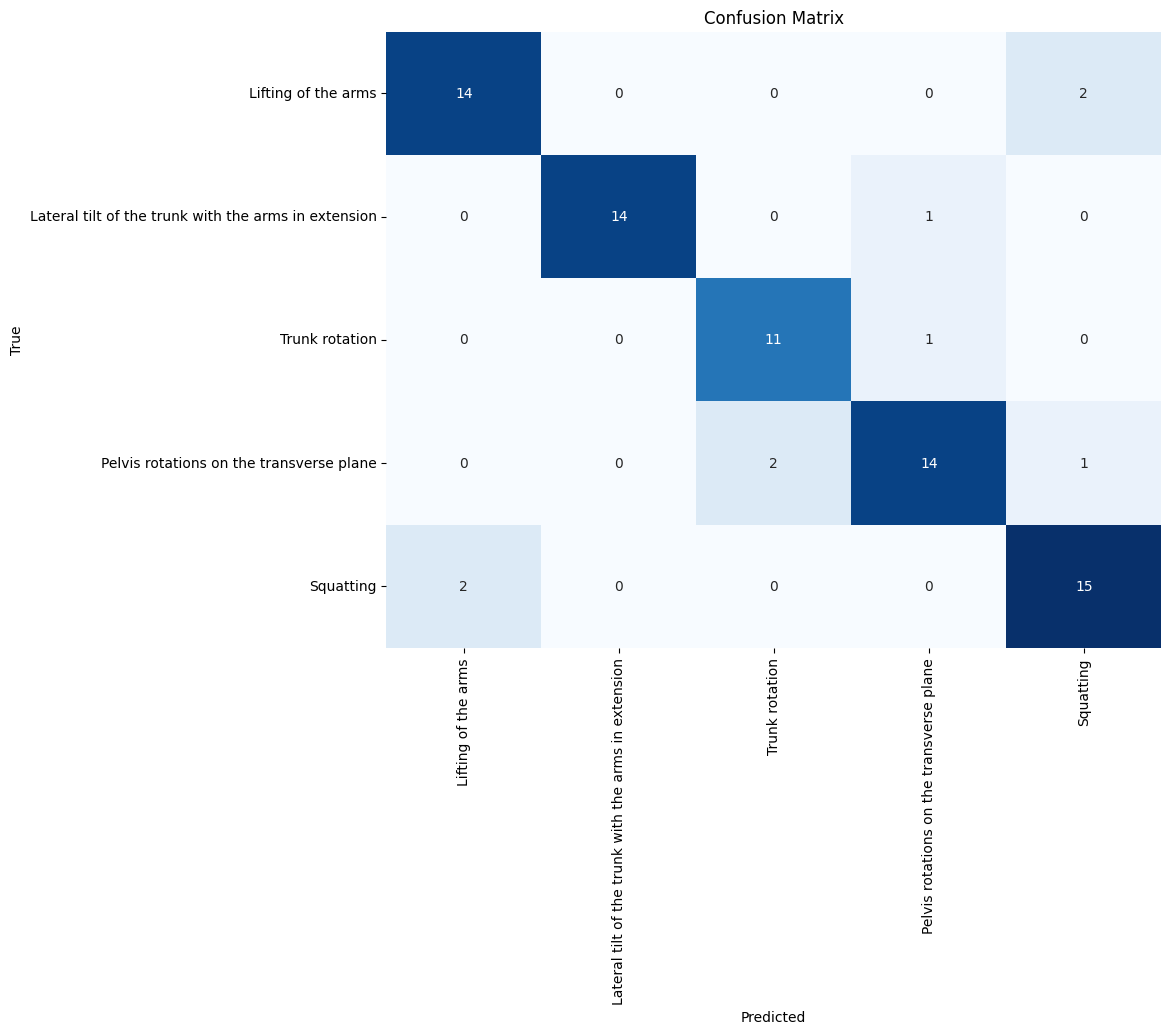

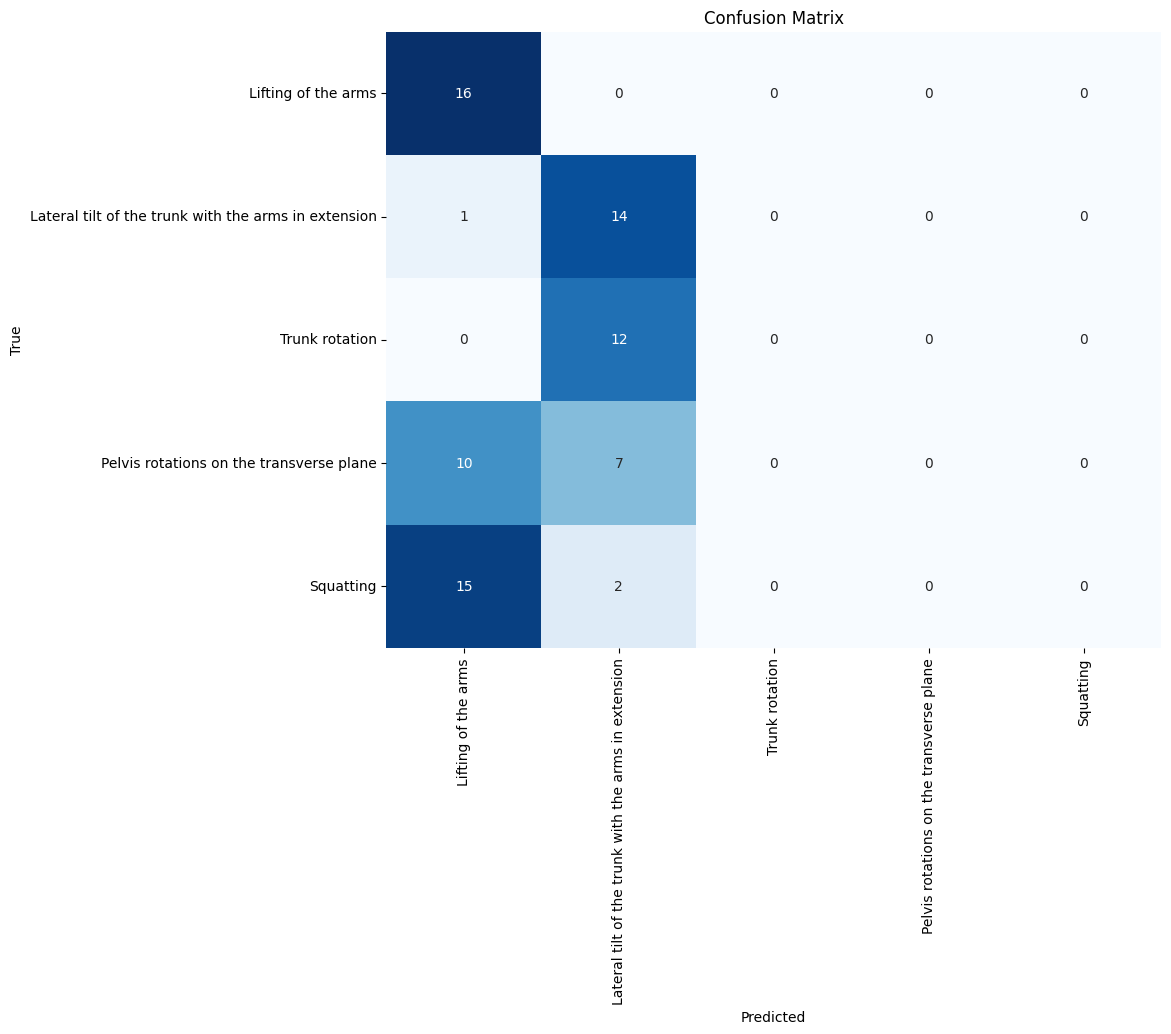

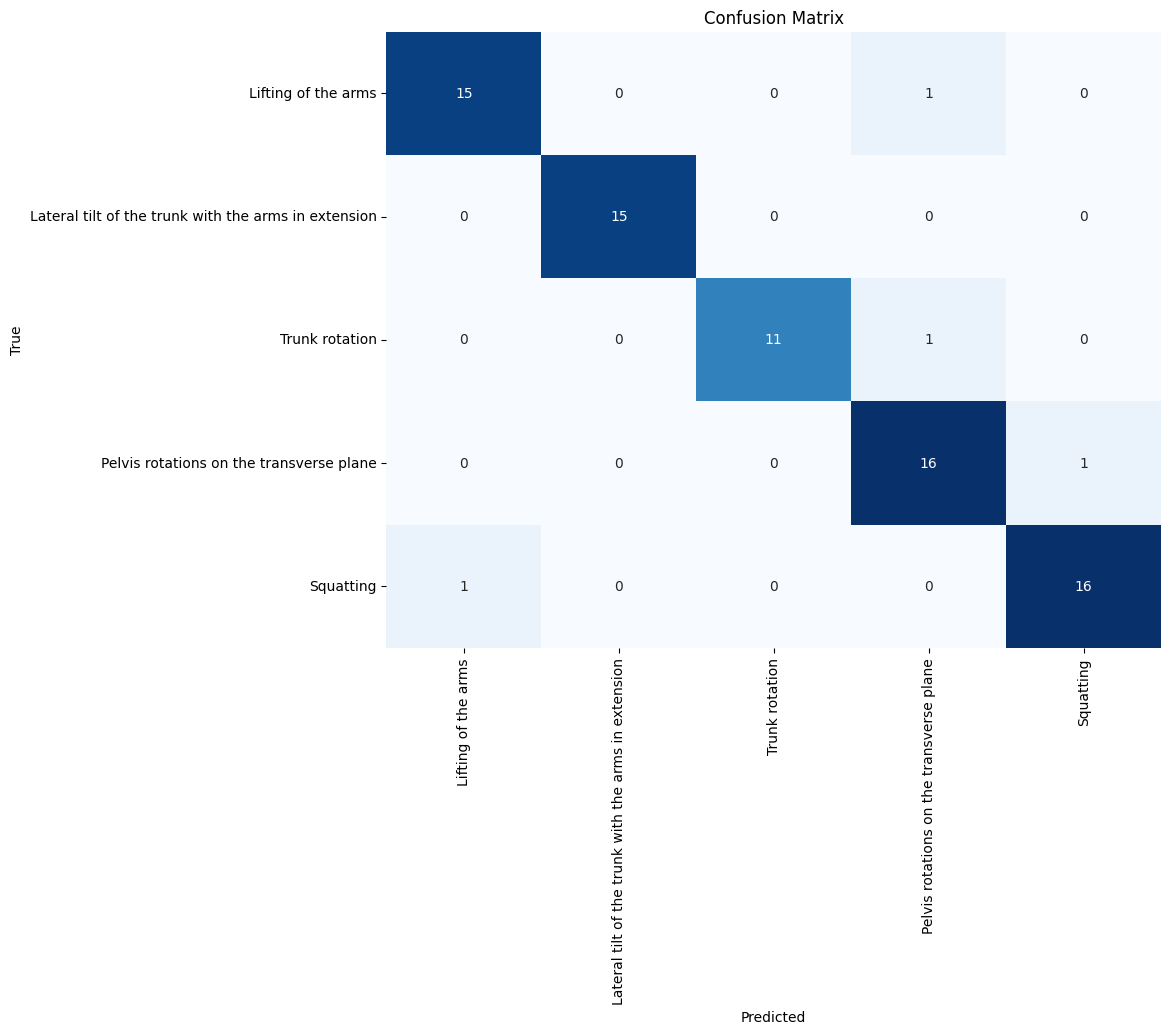

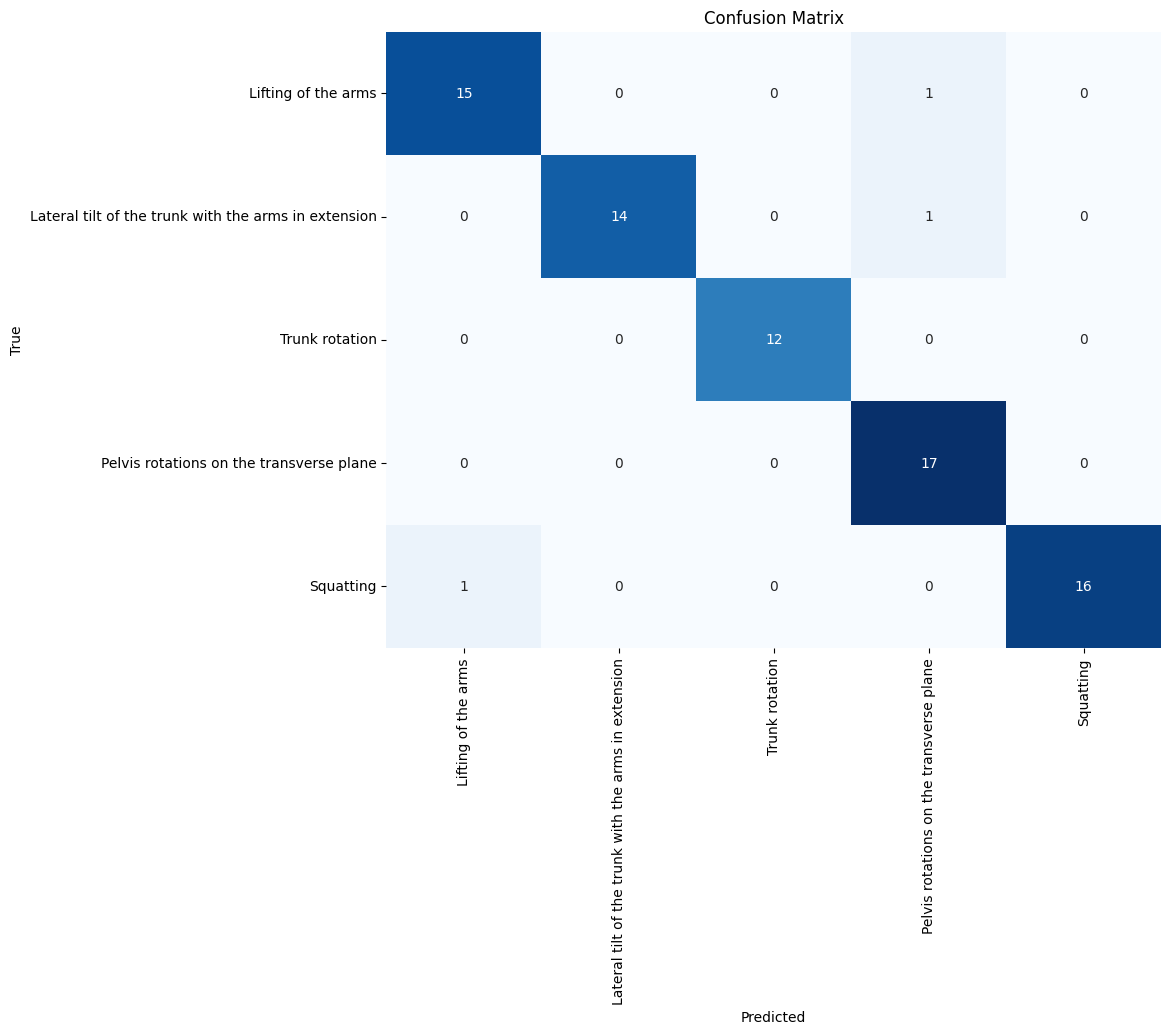

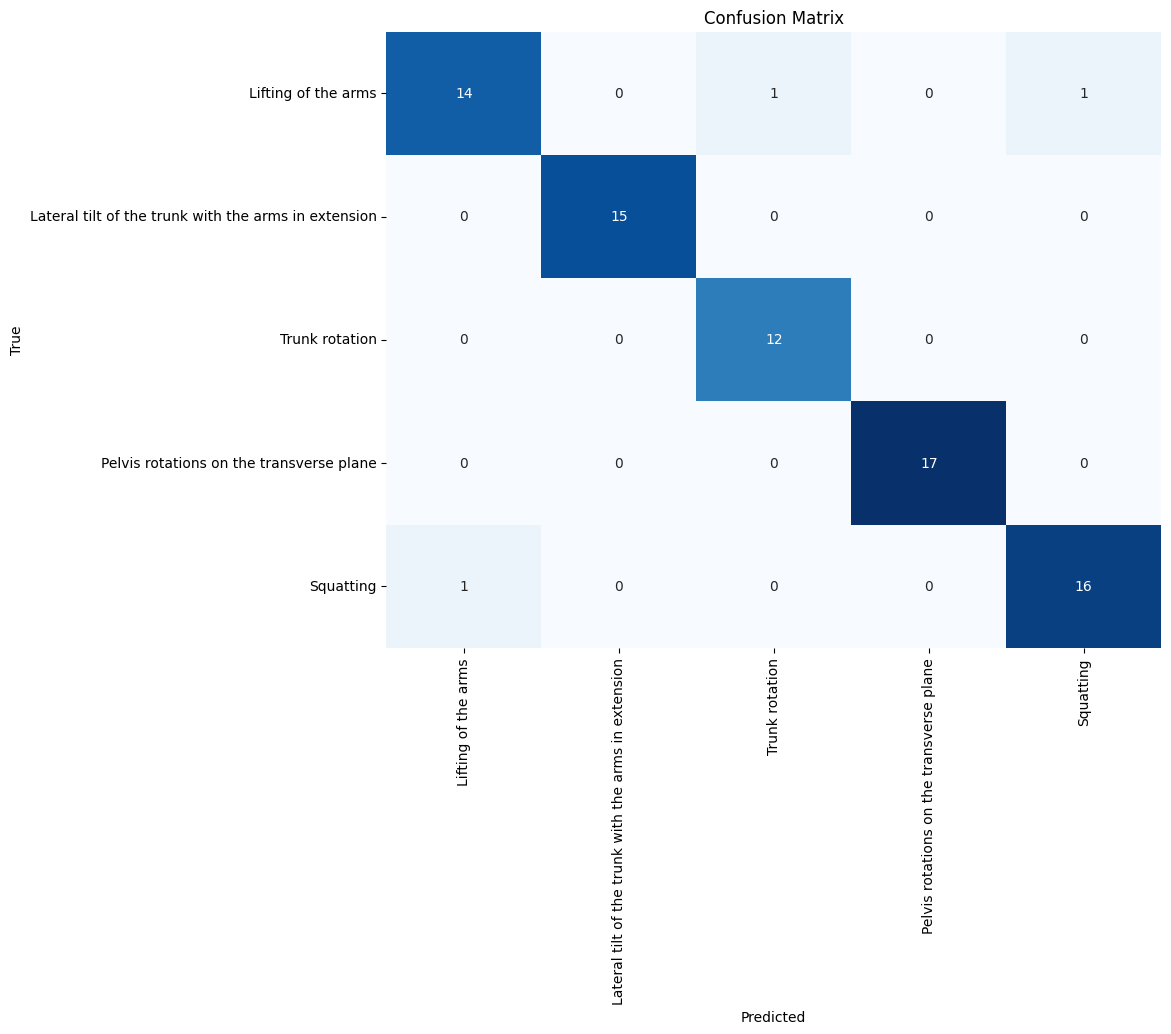

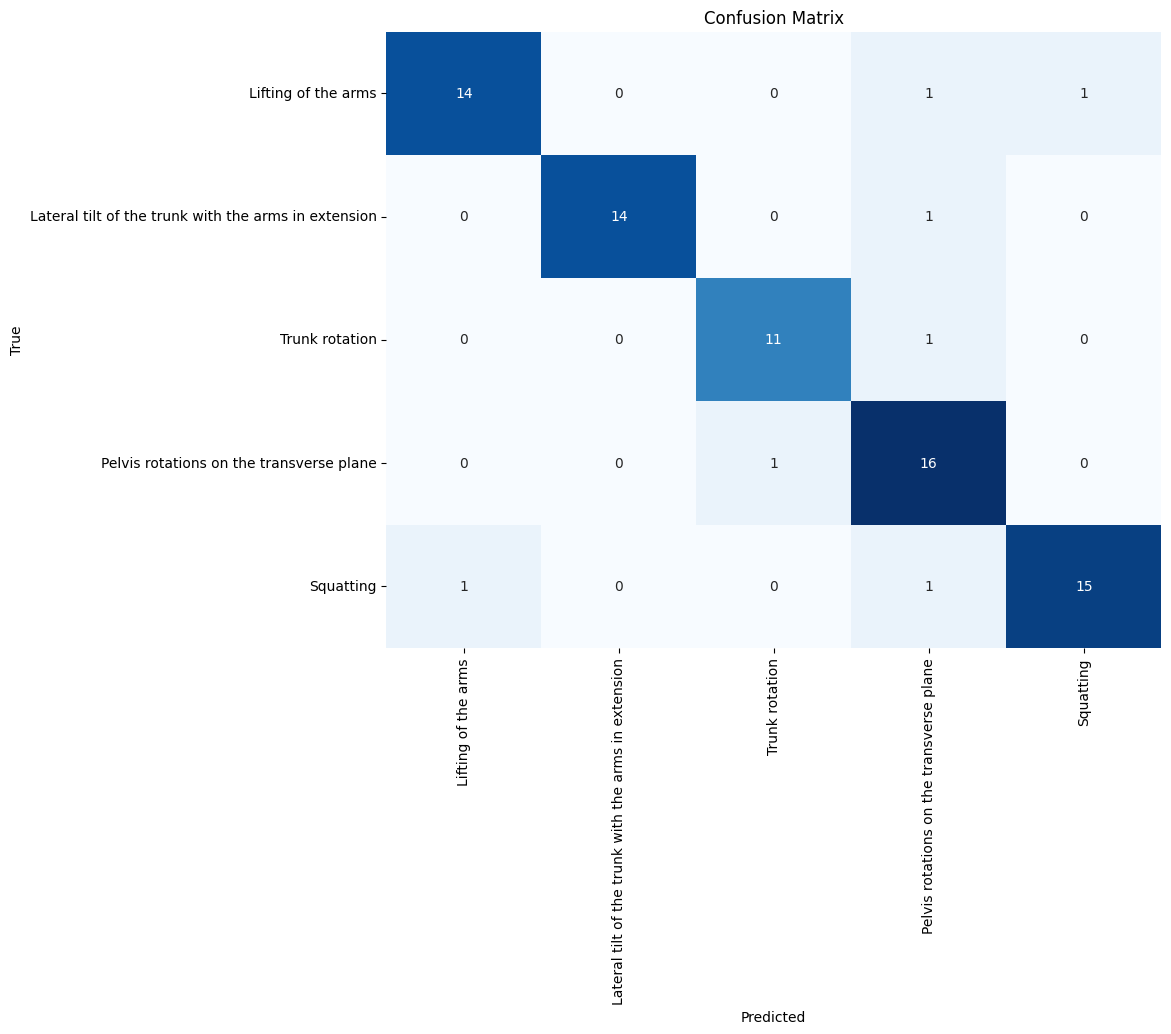

In [ ]:
fold_number = 3
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 4

Processing Model 1 of 6 : DenseNet201


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_6[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_6[0][0]']             
                                                          4                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 20s 3s/step
Accuracy: 0.8961038961038961
Precision: 0.9025696525696526
Recall: 0.8961038961038961
F1 Score: 0.8944533299213102
AUC: 0.9901640271493214
Confusion Matrix:
 [[12  3  1  0  1]
 [ 1 12  0  0  0]
 [ 0  0 16  1  0]
 [ 0  1  0 12  0]
 [ 0  0  0  0 17]]
Testing Time taken: 27.422011613845825 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 6 : ResNet101


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_10[0][0]']            
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_10[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 789ms/step
Accuracy: 0.8701298701298701
Precision: 0.8787878787878787
Recall: 0.8701298701298701
F1 Score: 0.8722244647244646
AUC: 0.9696634615384616
Confusion Matrix:
 [[14  0  0  0  3]
 [ 1 12  0  0  0]
 [ 0  1 15  1  0]
 [ 0  0  0 11  2]
 [ 2  0  0  0 15]]
Testing Time taken: 9.310894250869751 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 3 of 6 : VGG16


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_14[0][0]']            
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_14[0][0]']            
                                                          8                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 13s 2s/step
Accuracy: 0.8831168831168831
Precision: 0.8917260684177978
Recall: 0.8831168831168831
F1 Score: 0.8806111786407353
AUC: 0.9849396681749623
Confusion Matrix:
 [[12  2  1  0  2]
 [ 0 12  1  0  0]
 [ 0  0 15  2  0]
 [ 0  0  1 12  0]
 [ 0  0  0  0 17]]
Testing Time taken: 23.192863941192627 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 4 of 6 : vit


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_7 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 352)               270688    
                                                                 
 dropout_12 (Dropout)        (None, 352)               0         
                                                                 
 dense_16 (Dense)            (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 4s 104ms/step
Accuracy: 0.9090909090909091
Precision: 0.9191732637110788
Recall: 0.9090909090909091
F1 Score: 0.9078840351567625
AUC: 0.9871153846153847
Confusion Matrix:
 [[12  2  0  3  0]
 [ 1 12  0  0  0]
 [ 0  0 16  1  0]
 [ 0  0  0 13  0]
 [ 0  0  0  0 17]]
Testing Time taken: 3.698617935180664 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 5 of 6 : Res_Mob_ViT_best_arc


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_20[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_20[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 7s 650ms/step
Accuracy: 0.8831168831168831
Precision: 0.8885899814471244
Recall: 0.8831168831168831
F1 Score: 0.883339620612348
AUC: 0.9828648190045248
Confusion Matrix:
 [[12  0  0  0  5]
 [ 1 12  0  0  0]
 [ 0  0 16  1  0]
 [ 0  0  0 13  0]
 [ 2  0  0  0 15]]
Testing Time taken: 9.447544574737549 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 6 of 6 : MobileNetV3Large


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_24[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_24[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 523ms/step
Accuracy: 0.935064935064935
Precision: 0.9421898903101911
Recall: 0.935064935064935
F1 Score: 0.9332946034244736
AUC: 0.9918467194570135
Confusion Matrix:
 [[13  2  0  0  2]
 [ 0 13  0  0  0]
 [ 0  0 16  1  0]
 [ 0  0  0 13  0]
 [ 0  0  0  0 17]]
Testing Time taken: 6.827768087387085 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.


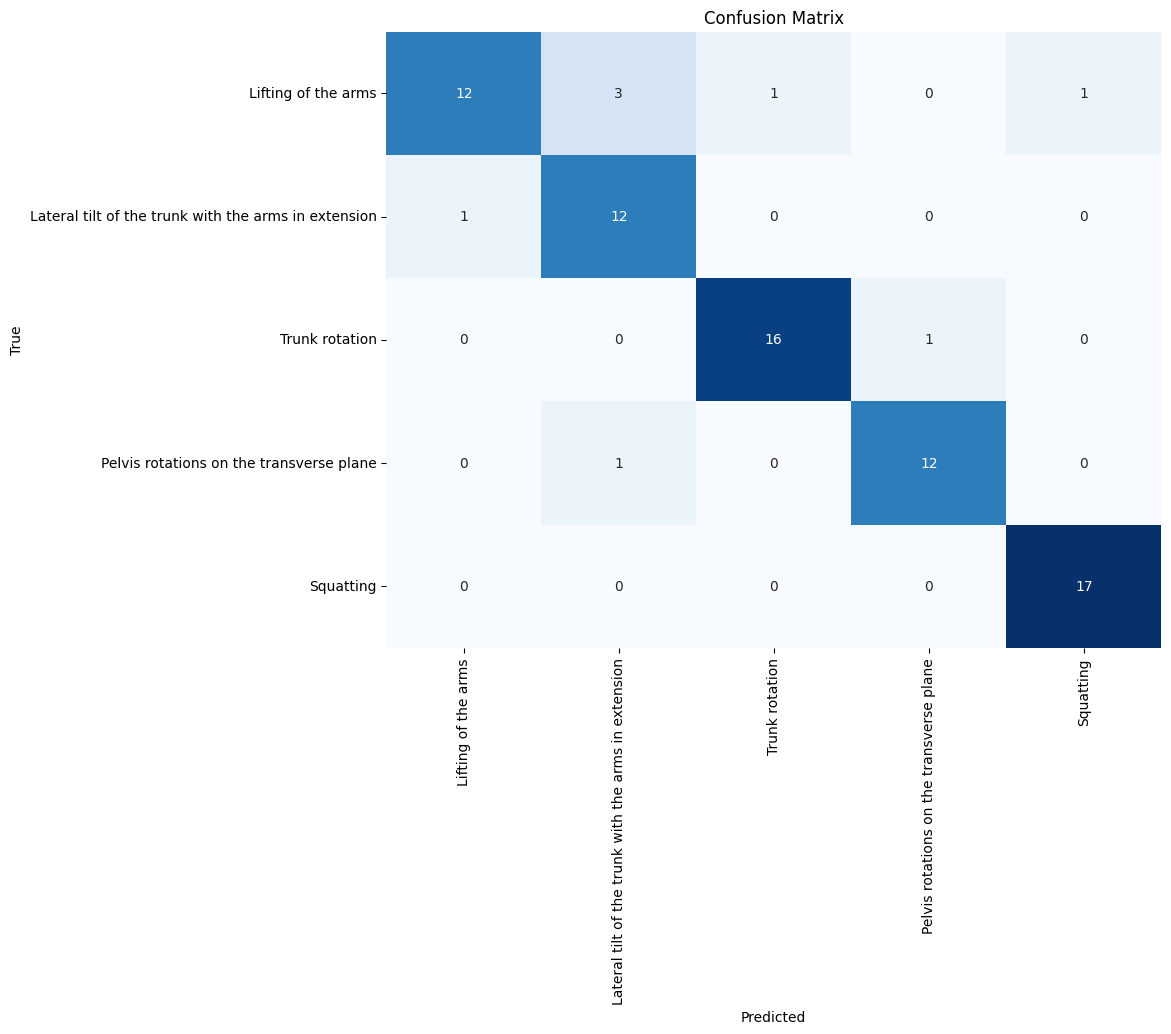

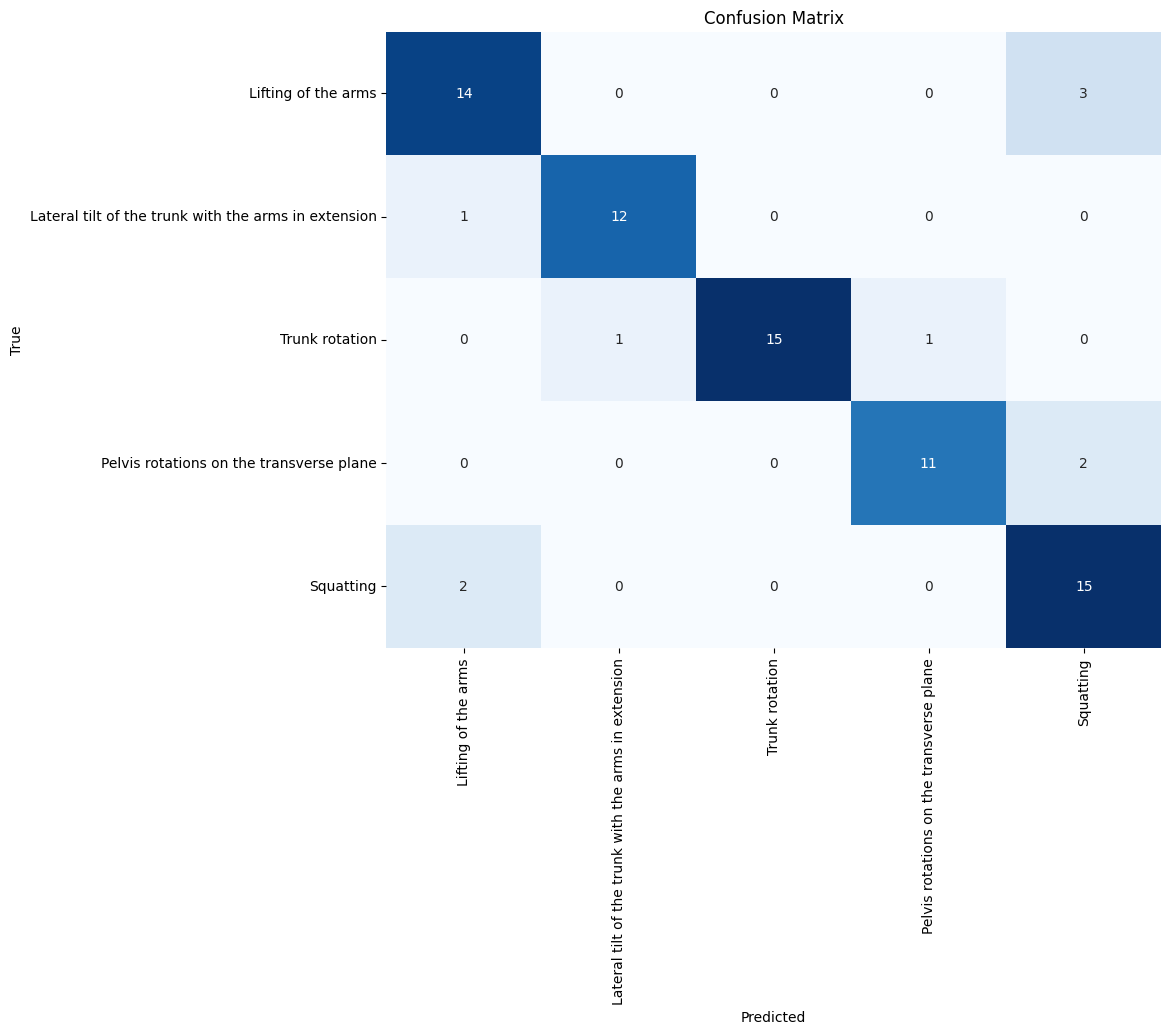

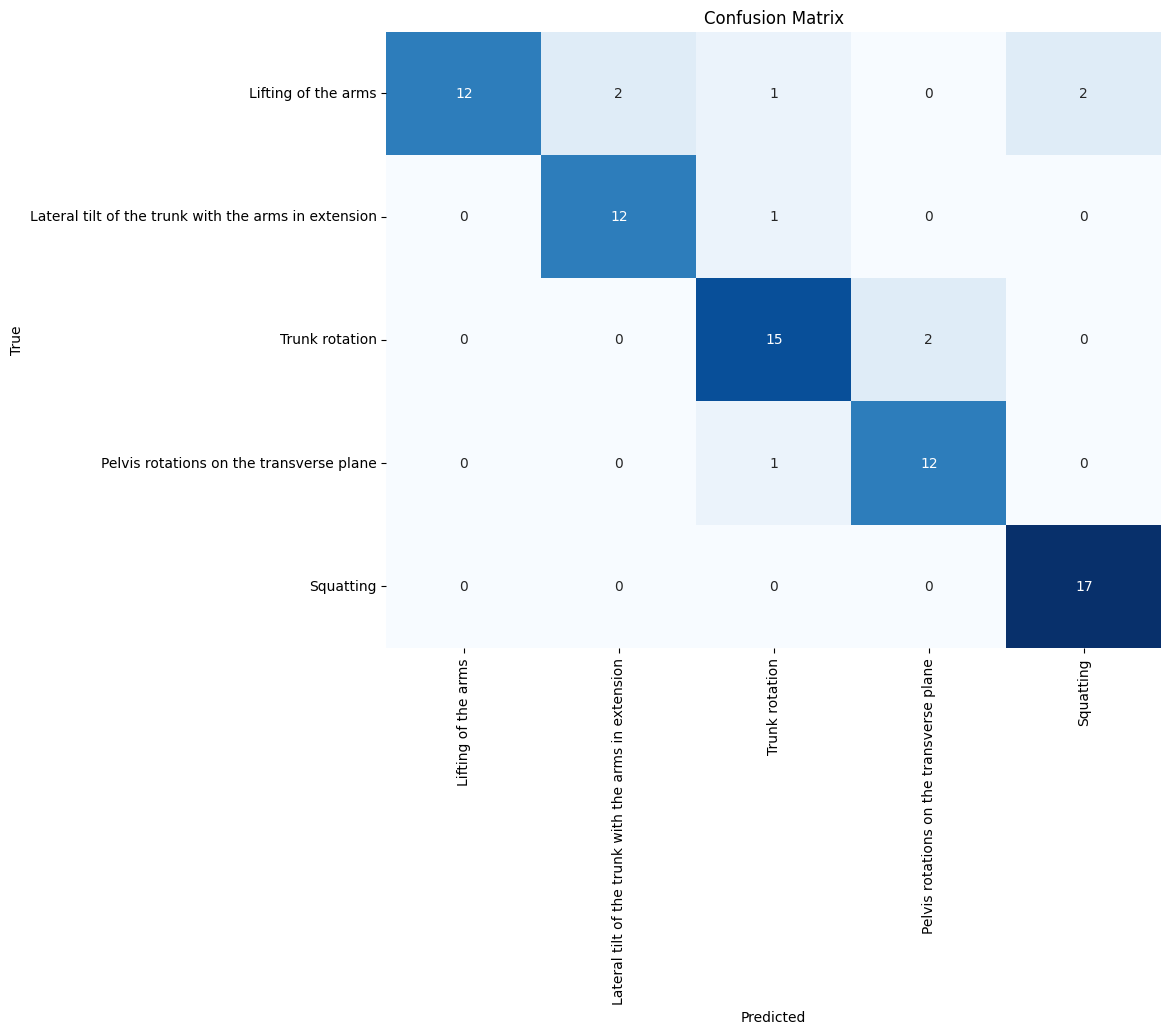

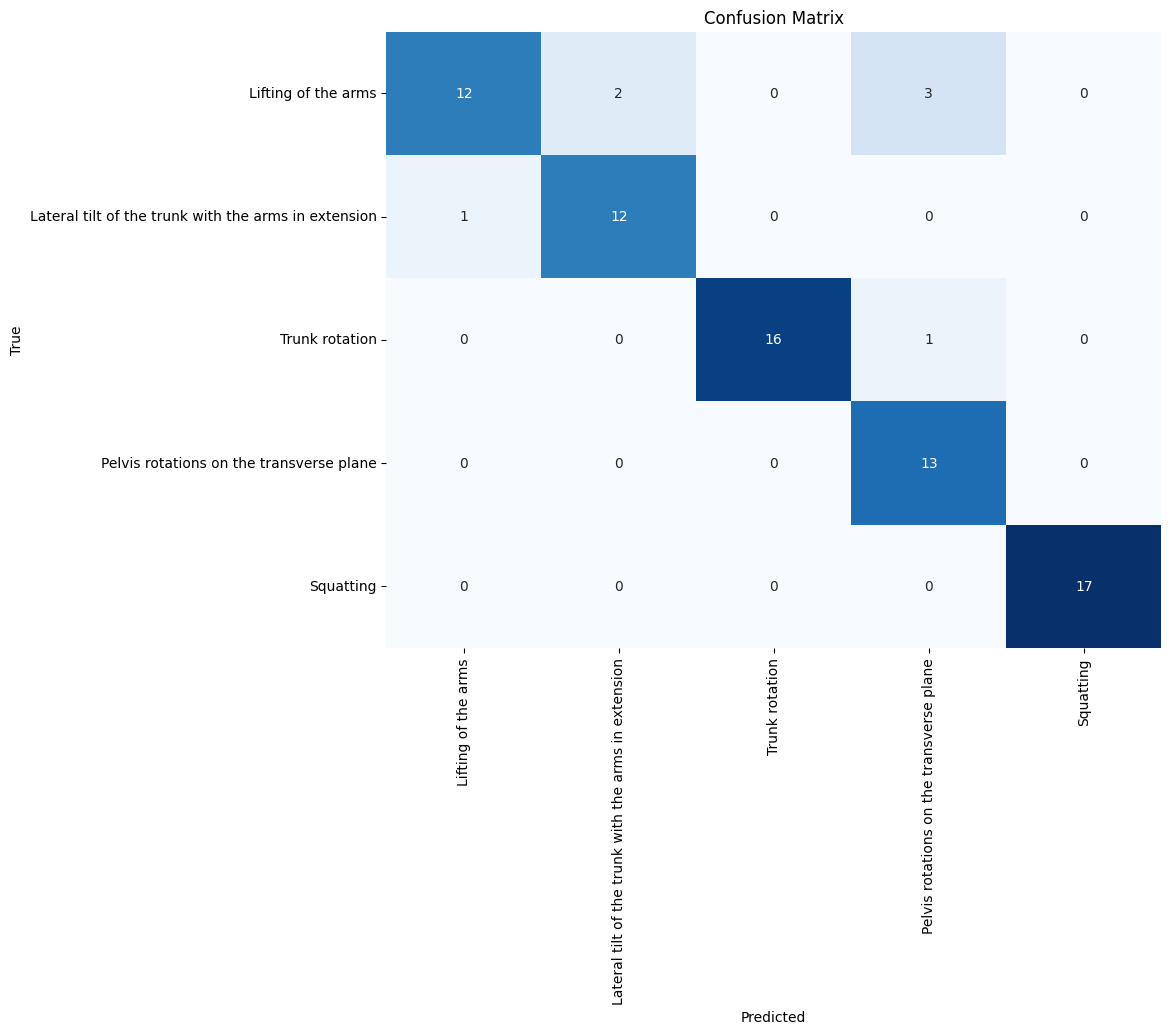

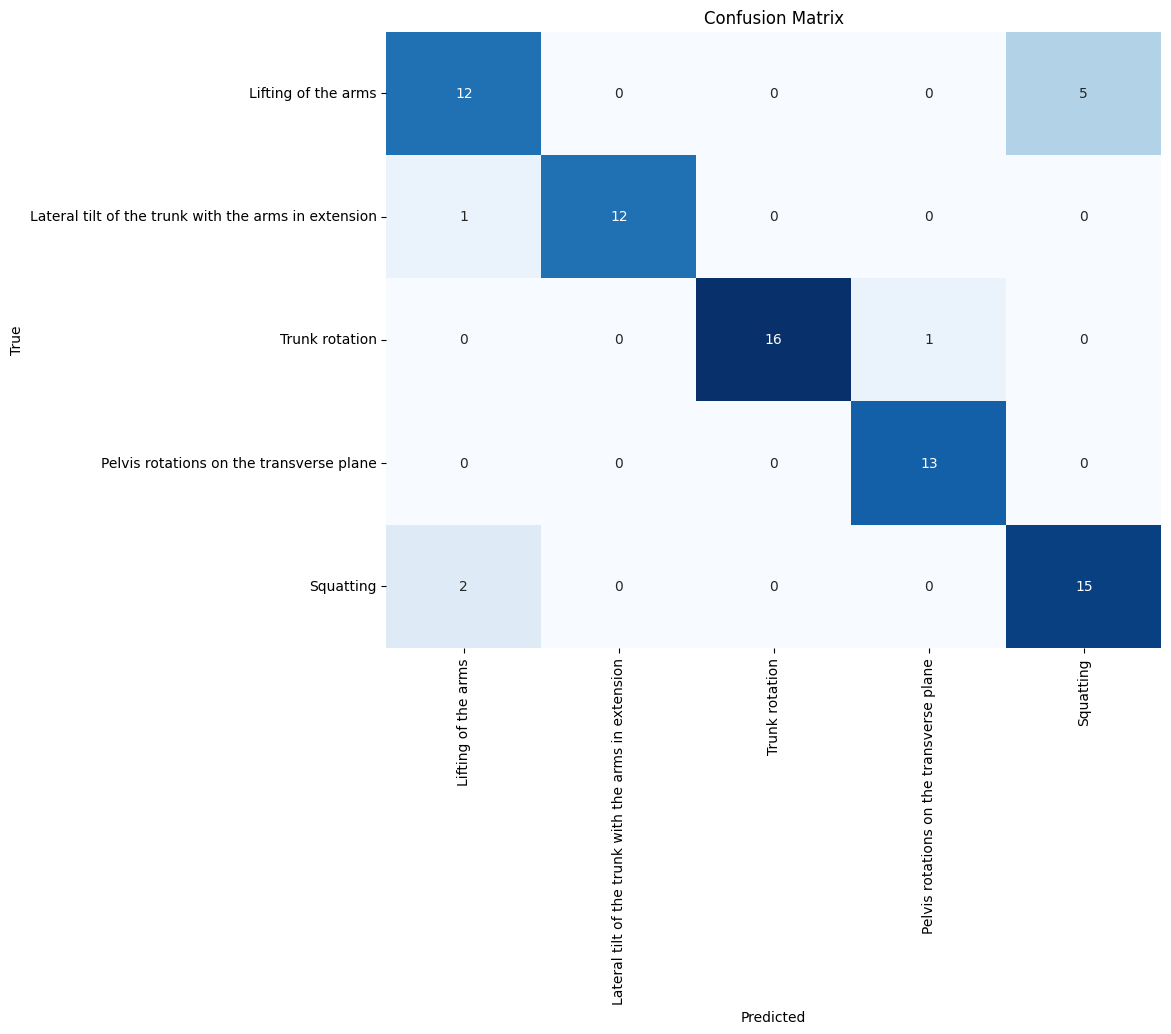

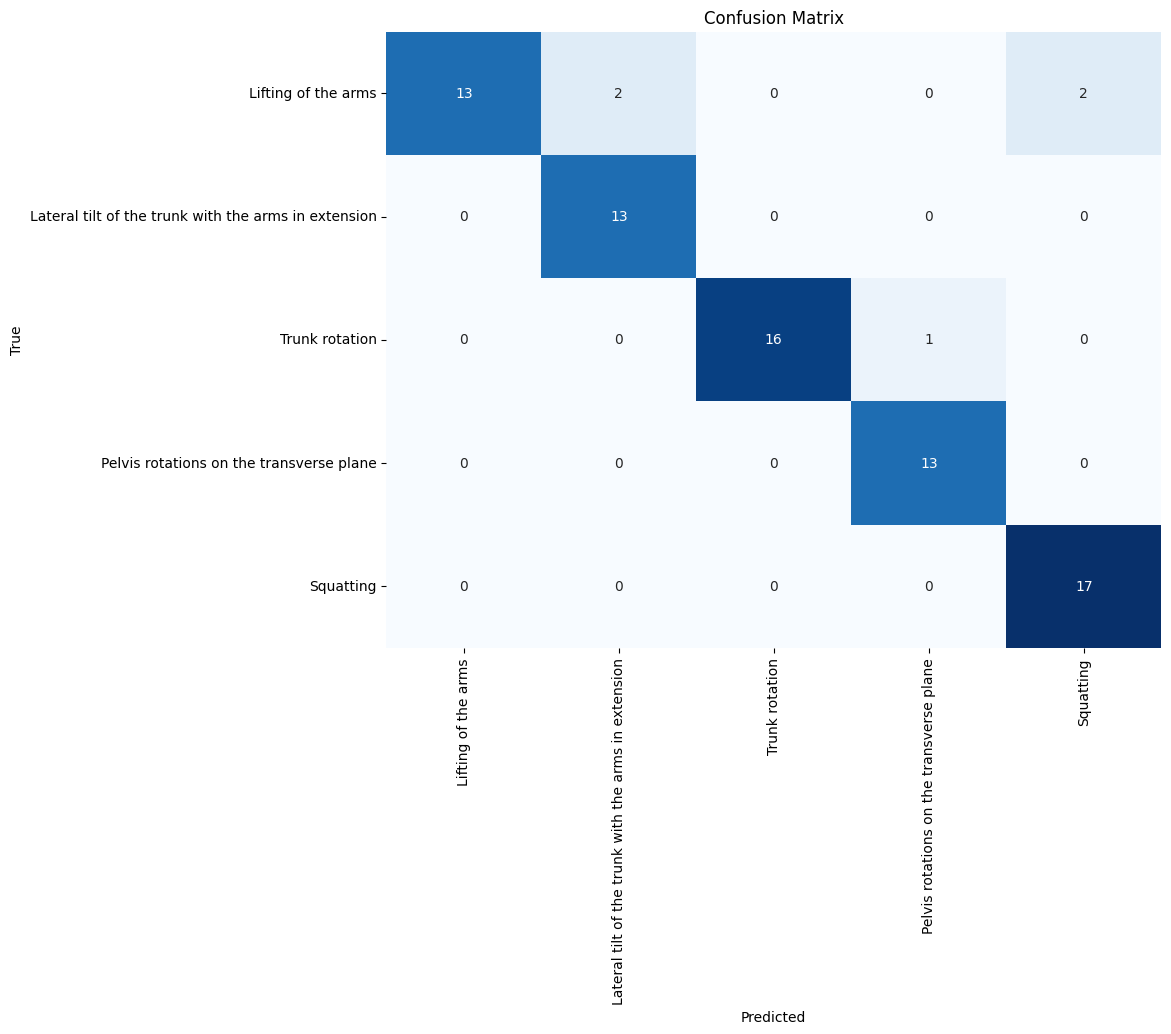

In [ ]:
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 5

Processing Model 1 of 6 : DenseNet201
353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


74836368/74836368 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 19s 3s/step
Accuracy: 0.9090909090909091
Precision: 0.913005654632449
Recall: 0.9090909090909091
F1 Score: 0.9081009429846639
AUC: 0.979426407263064
Confusion Matrix:
 [[20  0  0  1  0]
 [ 2 13  0  1  0]
 [ 0  3 12  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 19.131911993026733 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 6 : ResNet101


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


171446536/171446536 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_8[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_8[0][0]']             
                                                          6                                       
                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 974ms/step
Accuracy: 0.9090909090909091
Precision: 0.917099567099567
Recall: 0.9090909090909091
F1 Score: 0.9087731482689466
AUC: 0.9903772164603545
Confusion Matrix:
 [[17  2  0  2  0]
 [ 1 15  0  0  0]
 [ 0  1 13  1  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 9.03382420539856 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 3 of 6 : VGG16


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


58889256/58889256 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_12[0][0]']            
                                                          8                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 14s 2s/step
Accuracy: 0.948051948051948
Precision: 0.9480699855699855
Recall: 0.948051948051948
F1 Score: 0.9473434062846224
AUC: 0.9844304115088658
Confusion Matrix:
 [[19  1  0  1  0]
 [ 1 14  1  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 13.884222030639648 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 4 of 6 : vit


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 352)               270688    
                                                                 
 dropout_12 (Dropout)        (None, 352)               0         
                                                                 
 dense_16 (Dense)            (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 4s 105ms/step
Accuracy: 0.948051948051948
Precision: 0.9533189033189035
Recall: 0.948051948051948
F1 Score: 0.94833954276463
AUC: 0.9938217910114865
Confusion Matrix:
 [[19  0  0  1  1]
 [ 1 14  0  0  1]
 [ 0  0 15  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 4.05026912689209 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 5 of 6 : Res_Mob_ViT_best_arc
4334752/4334752 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_18[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_18[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 566ms/step
Accuracy: 0.961038961038961
Precision: 0.9632034632034633
Recall: 0.961038961038961
F1 Score: 0.9607406599003238
AUC: 0.9925616148098584
Confusion Matrix:
 [[20  0  0  0  1]
 [ 1 14  0  1  0]
 [ 0  0 15  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 6.77129864692688 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.
Processing Model 6 of 6 : MobileNetV3Large


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_22[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_22[0][0]']            
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 595ms/step
Accuracy: 0.948051948051948
Precision: 0.9495670995670996
Recall: 0.948051948051948
F1 Score: 0.947920399140618
AUC: 0.9861394557823129
Confusion Matrix:
 [[19  0  0  1  1]
 [ 1 15  0  0  0]
 [ 0  1 14  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 6.034210920333862 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.


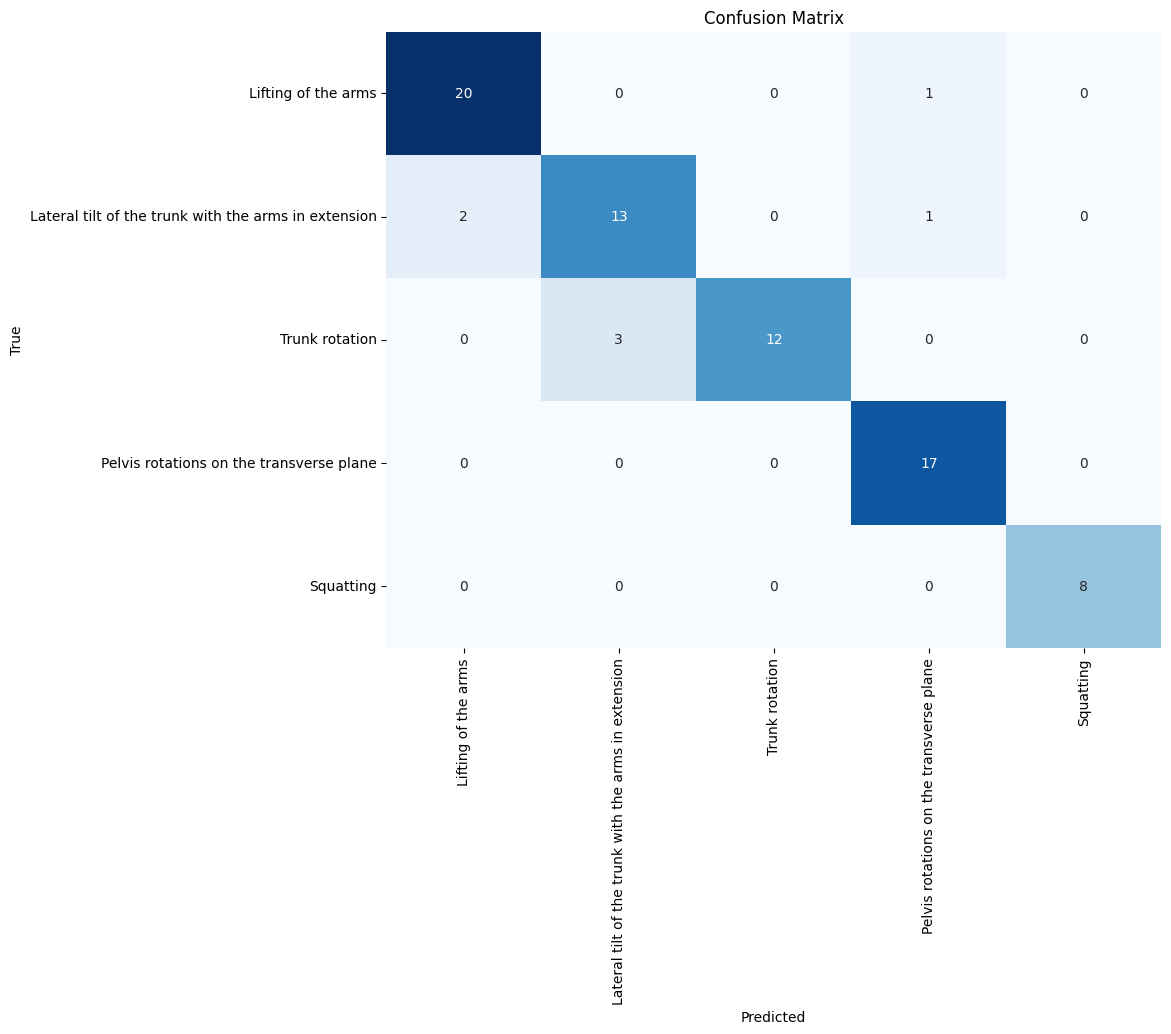

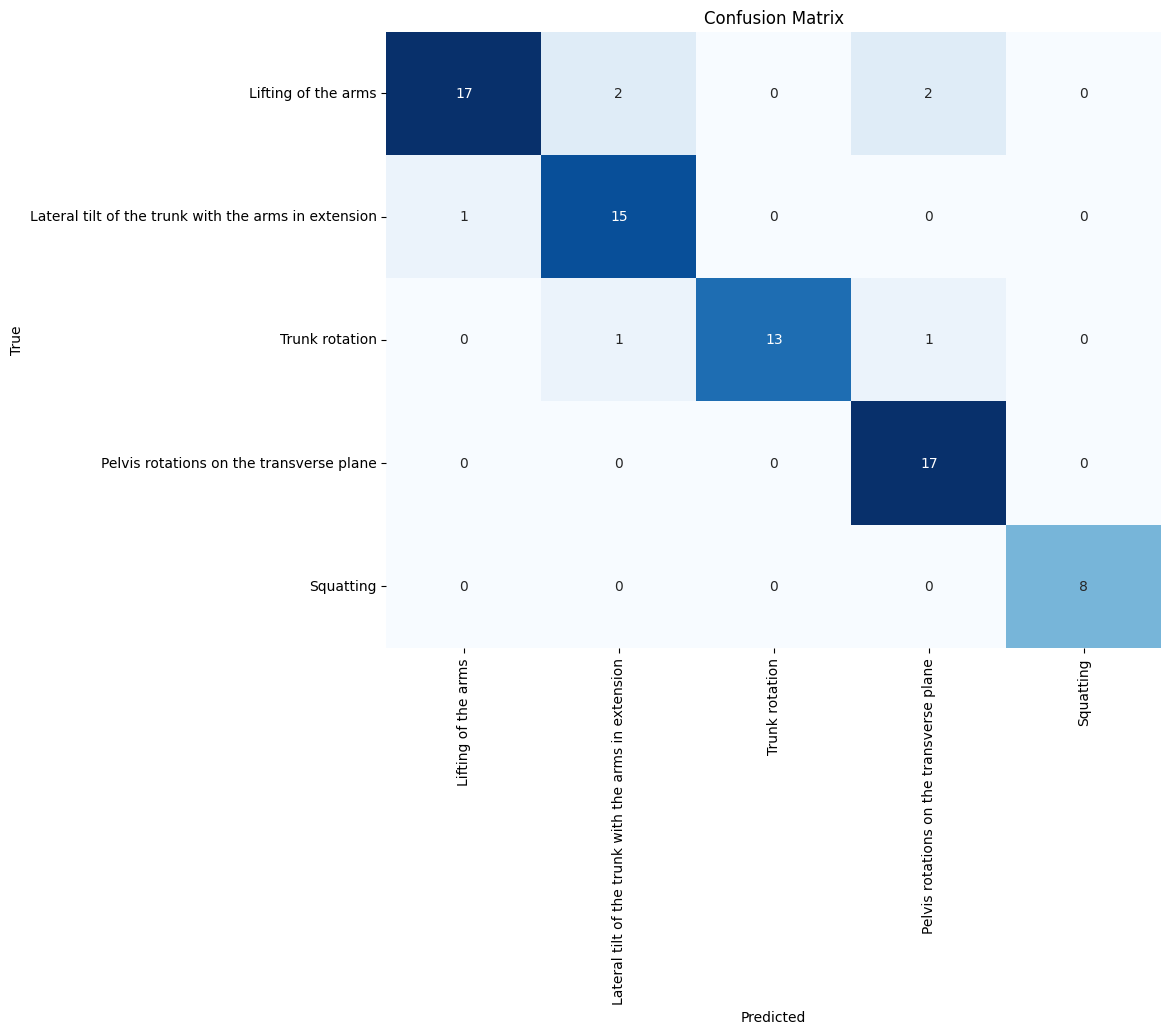

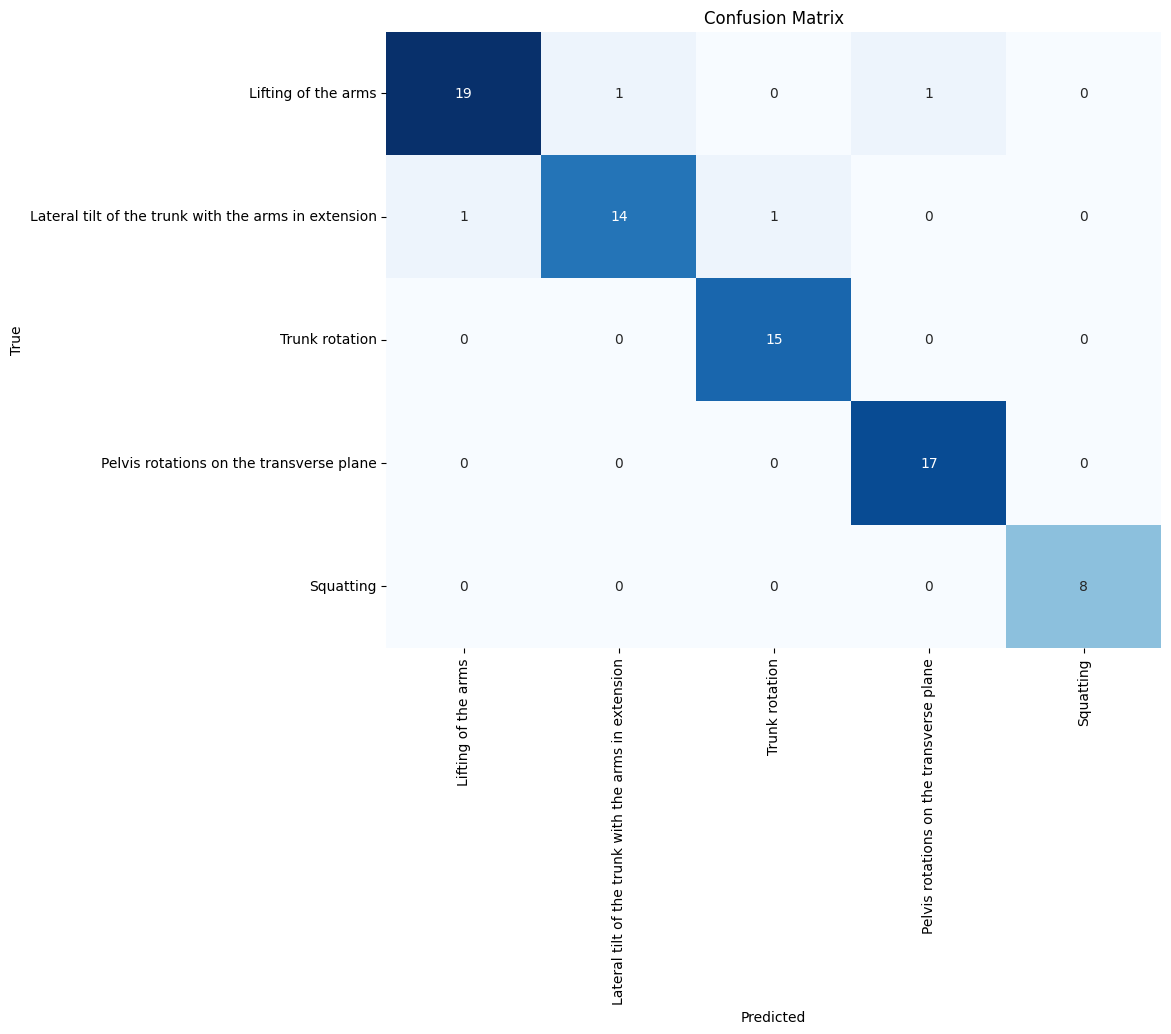

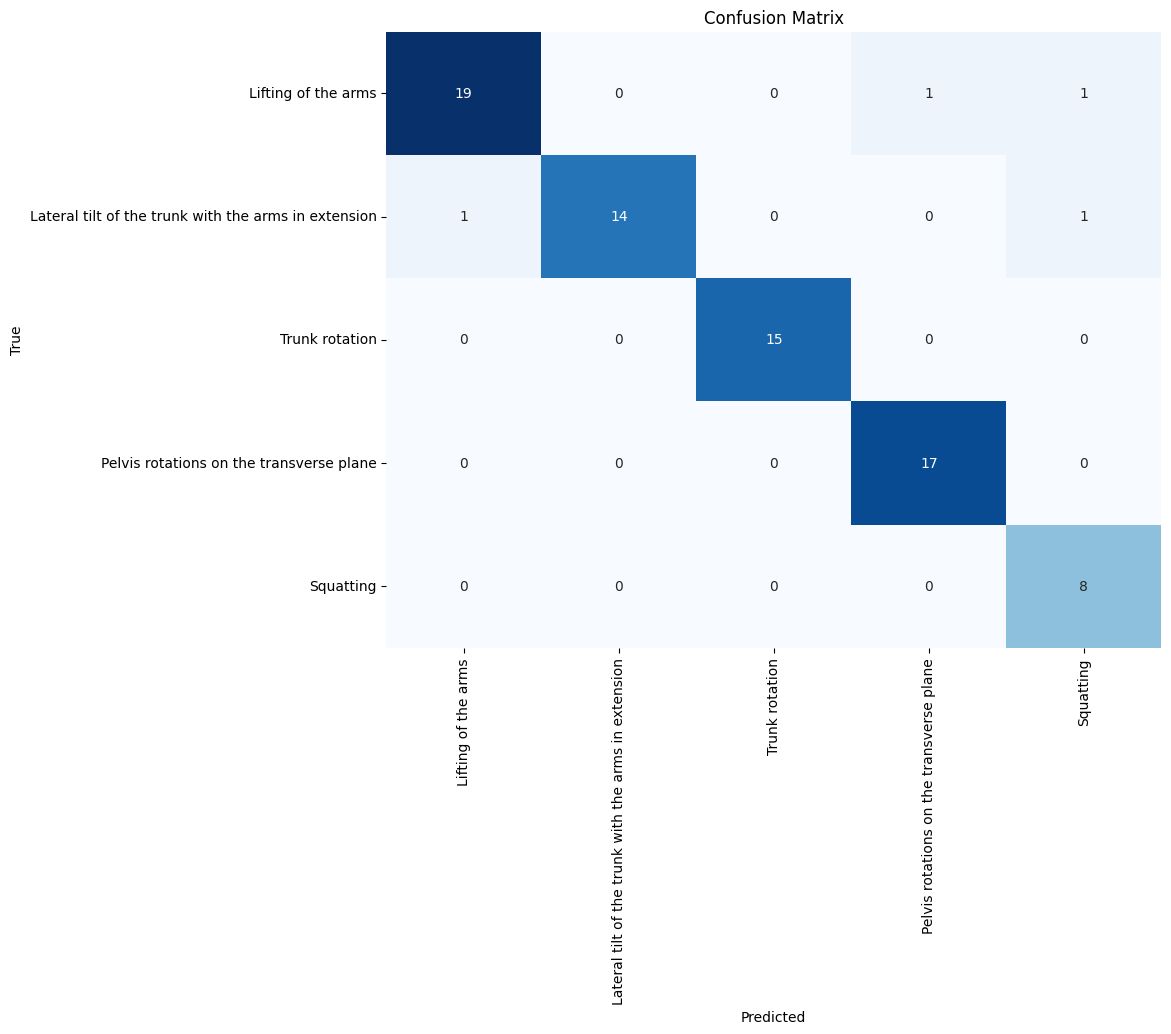

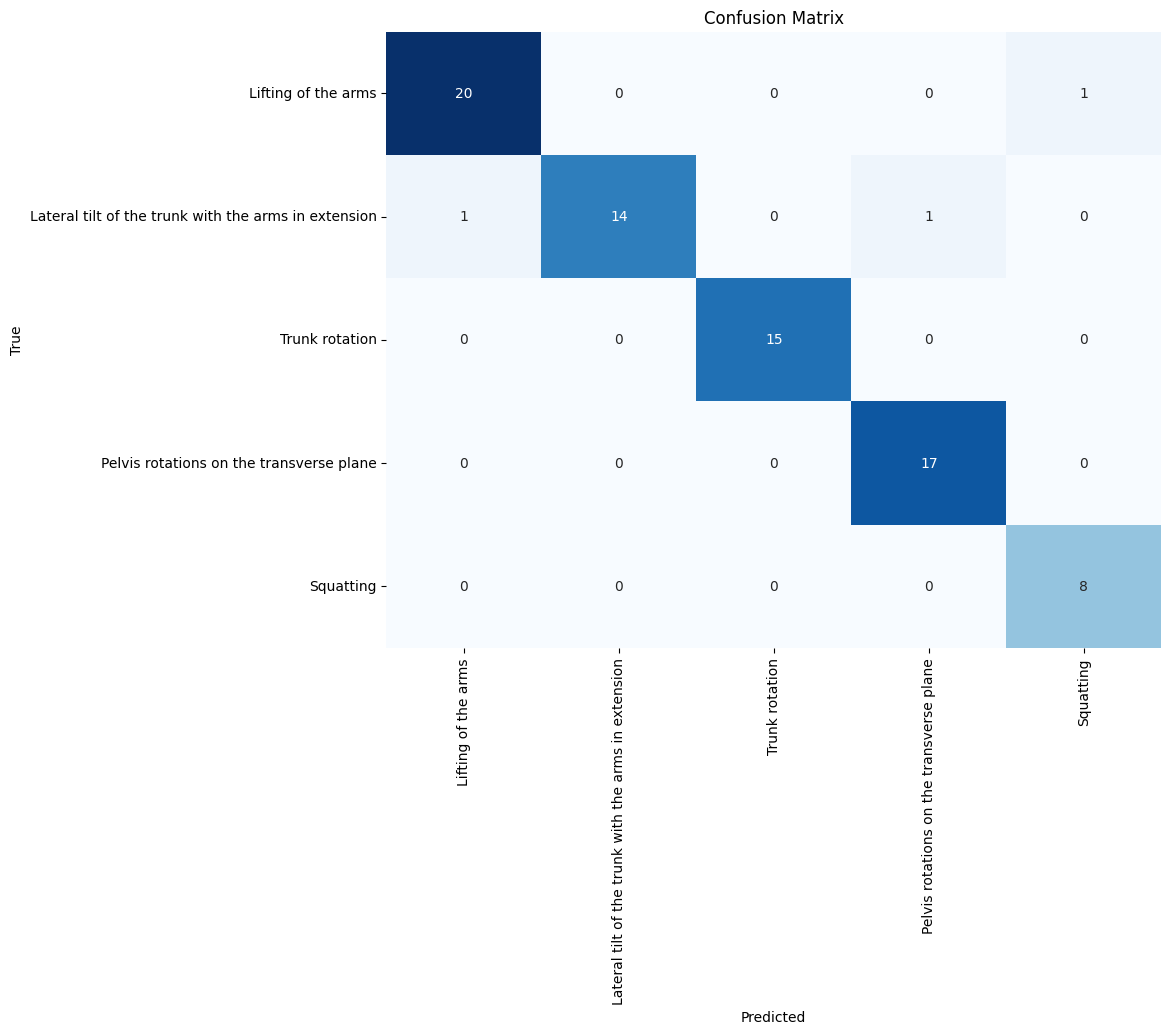

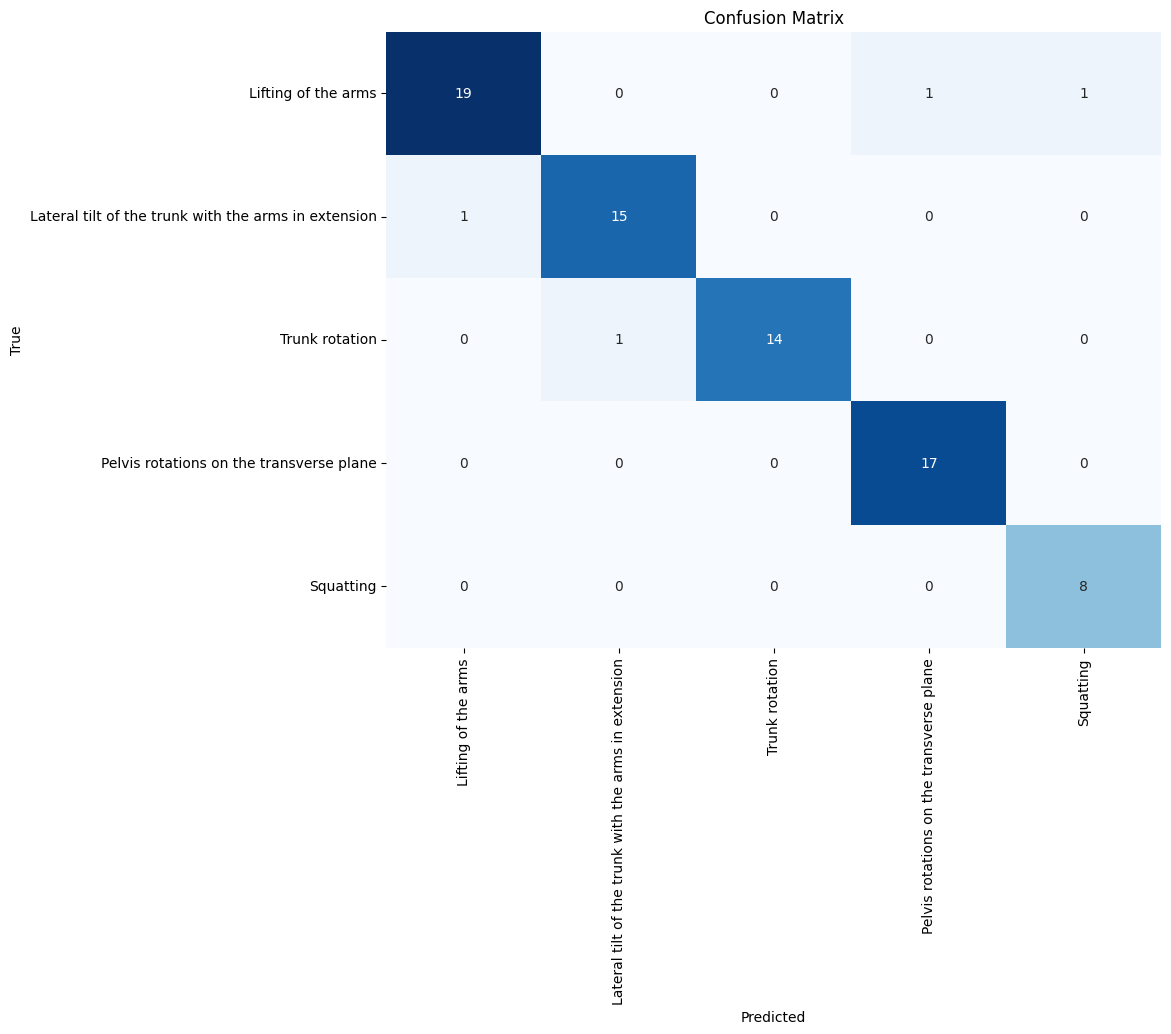

In [ ]:
fold_number = 5
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Res101ViT

Processing Model 1 of 1 : ResNet101


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_4[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_4[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 883ms/step
Accuracy: 0.935064935064935
Precision: 0.9385908209437621
Recall: 0.935064935064935
F1 Score: 0.9360137876752297
AUC: 0.9960641540104632
Confusion Matrix:
 [[15  0  1  0  0]
 [ 1 14  0  0  0]
 [ 0  0 11  1  0]
 [ 0  0  1 16  0]
 [ 1  0  0  0 16]]
Testing Time taken: 9.204529523849487 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense-kimore/cv/results_cv.csv' successfully.


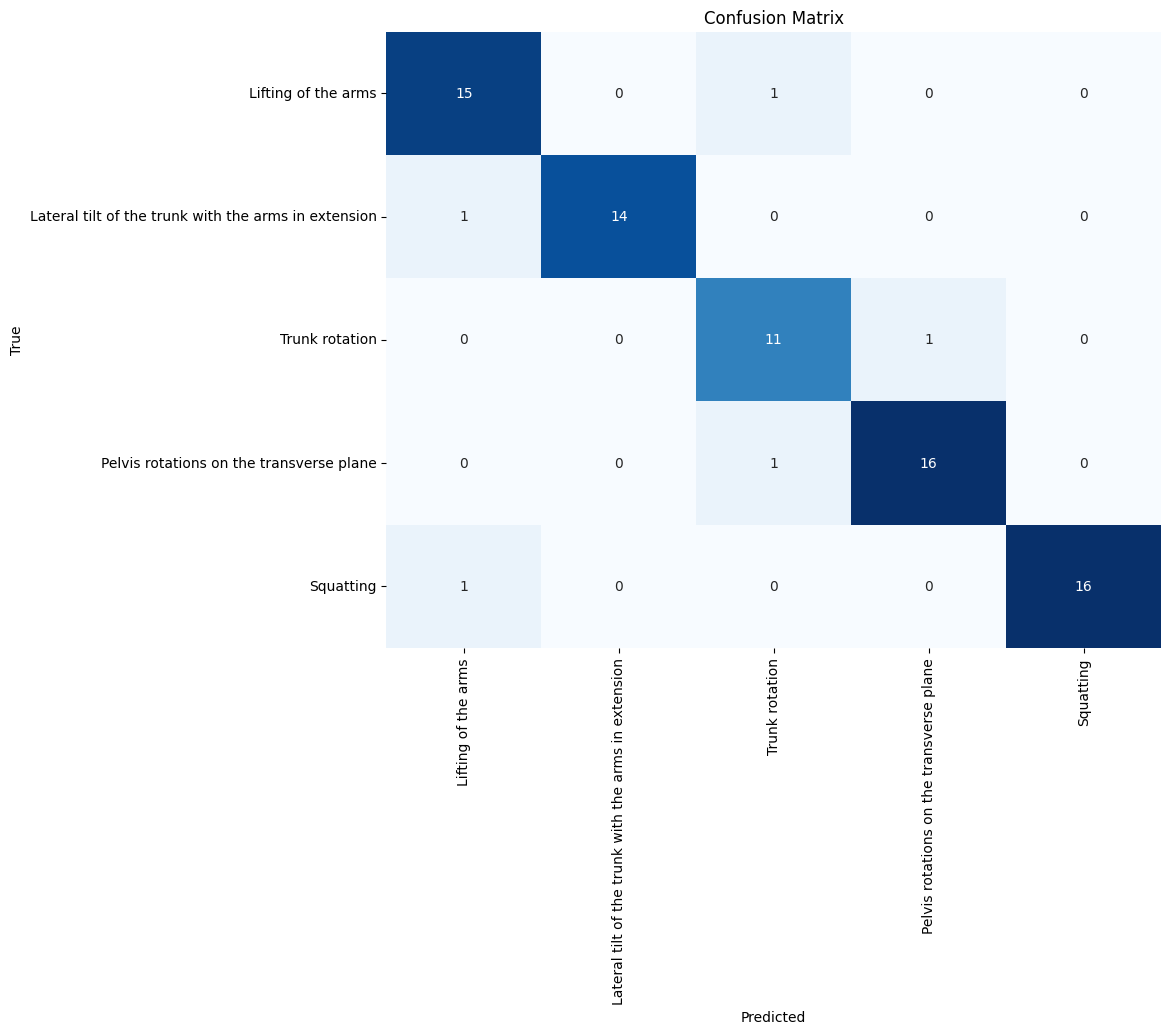

In [ ]:
model_names=['ResNet101']
patience=50
fold_number = 3
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

#Transfomer on Images from Original Data

In [ ]:
# Example usage:
folder_path = '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images/'
Oimages, Olabels = load_images_and_labels(folder_path)
labels = encode_labels(Olabels)  # Add your label encoding function
resized_images = resize_images_cv2(Oimages)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_images, labels, test_size=0.2, validation_size=0.1, random_state=42)


In [ ]:
del Oimages,Olabels,resized_images

##ResVIT

In [ ]:
model_name="ResNetVisionTransformerOriginalData"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createVitWithResNet101(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_10[0][0]']            
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_10[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1692.28253531456 seconds


13/13 [==============================] - 10s 320ms/step
Accuracy: 0.305
Precision: 0.29315877225665316
Recall: 0.305
F1 Score: 0.2875652671968199
AUC: 0.8453486842105263
Confusion Matrix:
 [[16  0  0  0  0  1  1  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  2  0  0  1  2  1  2  1  5  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  3  8  0  1  3  0  0  0  1  0]
 [ 0  0  3  5  0  0  1  1  0  0  1  2  0  0  1  0  0  0  4  2]
 [ 0  0  0  0 13  5  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  7  6  2  1  1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  3  0  1  0  1 10  1  1  1  0  0  0  0  0  0  0  2  0  0]
 [ 0  1  1  0  1  4  4  4  1  0  2  1  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0 15  2  0  0  0  0  0  0  0  0  0  1]
 [ 3  1  0  0  0  0  0  0  3 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  1  1  0  0  5  3  2  0  2  1  1  0  0  1]
 [ 0  0  1  1  0  0  1  4  0  0  2  5  1  1  0  0  1  0  2  1]
 [ 0  0  0  0  0  0  1  0  0  0  4  0  6  0  4  0  0  2

<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer/results.csv' successfully.


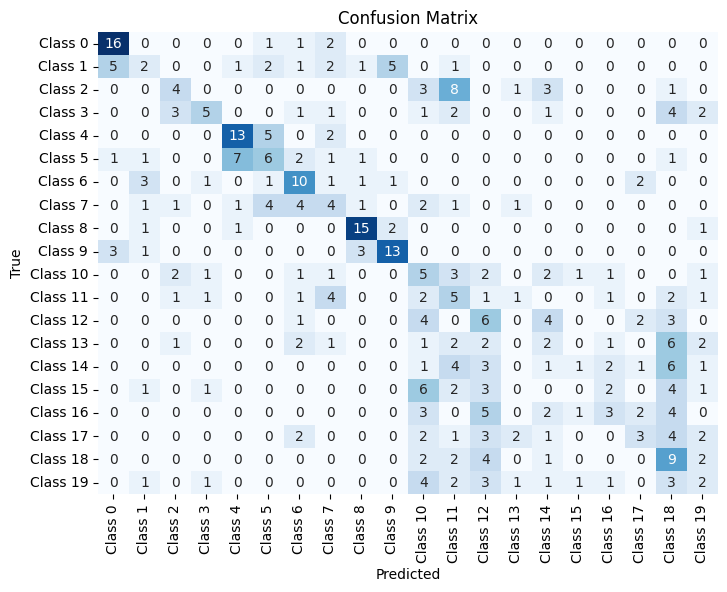

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


## MobileVit

In [ ]:
model_name="HybridMobileVisionTransformerOriginalData"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createMobileVit(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

NameError: ignored

13/13 [==============================] - 7s 189ms/step
Accuracy: 0.2875
Precision: 0.29804409079764044
Recall: 0.2875
F1 Score: 0.27990495076042504
AUC: 0.8354144736842104
Confusion Matrix:
 [[10  3  0  0  0  5  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  5  0  0  0  1  0  2  1  3  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  3  2  1  2  3  1  1  0  1  2]
 [ 0  0  0  6  0  0  1  1  0  0  2  2  1  0  0  0  0  0  3  4]
 [ 2  1  0  0  9  4  2  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  1  0  0  5  8  1  3  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  2  9  2  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 2  5  0  1  0  3  0  7  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 2  2  0  0  1  0  0  1  9  4  0  1  0  0  0  0  0  0  0  0]
 [ 3  3  0  0  0  1  0  2  1 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  4  0  0  0  2  0  0  4  4  2  0  1  0  0  0  0  1]
 [ 0  1  0  1  0  0  0  3  0  0  5  5  1  0  2  0  0  0  1  1]
 [ 0  0  0  3  0  0  1  0  0  0  2  0  8  0  1  0  0 

<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer/results.csv' successfully.


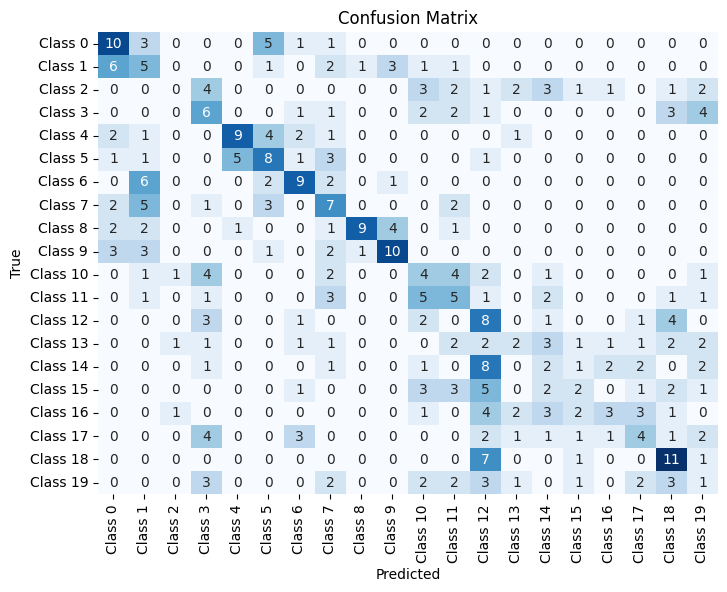

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration,durationt)

# Specs

In [ ]:
!pip install psutil gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=2e9a20440844545724767252a3bd3ee78857cabcee054e8e19a5fe8fb1f732ef
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
import GPUtil

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

# Iterate over each GPU and print information
for i, gpu in enumerate(gpus):
    print(f"GPU {i + 1}:")
    print(f"  Name: {gpu.name}")
    print(f"  ID: {gpu.id}")
    print(f"  Driver: {gpu.driver}")
    print(f"  GPU Memory Total: {gpu.memoryTotal} MB")
    print(f"  GPU Memory Free: {gpu.memoryFree} MB")
    print(f"  GPU Memory Used: {gpu.memoryUsed} MB")
    print(f"  GPU Load: {gpu.load * 100}%")
    print(f"  GPU Temperature: {gpu.temperature} °C")
    print()

# If you just want the name of the first GPU, you can do:
if gpus:
    first_gpu_name = gpus[0].name
    print(f"Name of the first GPU: {first_gpu_name}")


GPU 1:
  Name: Tesla T4
  ID: 0
  Driver: 525.105.17
  GPU Memory Total: 15360.0 MB
  GPU Memory Free: 15101.0 MB
  GPU Memory Used: 0.0 MB
  GPU Load: 0.0%
  GPU Temperature: 56.0 °C

Name of the first GPU: Tesla T4


In [ ]:
import psutil
import platform
import cpuinfo
import GPUtil

# Get basic system information
system_info = platform.uname()
print("System Information:")
print(f"  System: {system_info.system}")
print(f"  Node Name: {system_info.node}")
print(f"  Release: {system_info.release}")
print(f"  Version: {system_info.version}")
print(f"  Machine: {system_info.machine}")
print(f"  Processor: {system_info.processor}")

# Get CPU information
cpu_info = cpuinfo.get_cpu_info()
print("\nCPU Information:")
print(f"  CPU Brand: {cpu_info['brand_raw']}")
print(f"  Architecture: {cpu_info['arch']}")
print(f"  Cores: {psutil.cpu_count(logical=False)} (Physical)")
print(f"  Threads: {psutil.cpu_count(logical=True)} (Logical)")
print(f"  Max Frequency: {psutil.cpu_freq().max:.2f} MHz")

# Get Memory information
memory_info = psutil.virtual_memory()
print("\nMemory Information:")
print(f"  Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"  Available Memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"  Used Memory: {memory_info.used / (1024 ** 3):.2f} GB")

# Get GPU information
gpus = GPUtil.getGPUs()
if gpus:
    print("\nGPU Information:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i + 1}:")
        print(f"    Name: {gpu.name}")
        print(f"    Driver: {gpu.driver}")
        print(f"    GPU Memory Total: {gpu.memoryTotal} MB")
        print(f"    GPU Memory Free: {gpu.memoryFree} MB")
        print(f"    GPU Memory Used: {gpu.memoryUsed} MB")
        print(f"    GPU Load: {gpu.load * 100}%")
        print(f"    GPU Temperature: {gpu.temperature} °C")
        print()

# Additional information can be gathered using other psutil functions
# For example, disk information, network information, etc.


System Information:
  System: Linux
  Node Name: 5a32522e0dc7
  Release: 5.15.120+
  Version: #1 SMP Wed Aug 30 11:19:59 UTC 2023
  Machine: x86_64
  Processor: x86_64

CPU Information:
  CPU Brand: Intel(R) Xeon(R) CPU @ 2.00GHz
  Architecture: X86_64
  Cores: 1 (Physical)
  Threads: 2 (Logical)
  Max Frequency: 0.00 MHz

Memory Information:
  Total Memory: 12.68 GB
  Available Memory: 11.82 GB
  Used Memory: 0.59 GB

GPU Information:
  GPU 1:
    Name: Tesla T4
    Driver: 525.105.17
    GPU Memory Total: 15360.0 MB
    GPU Memory Free: 15101.0 MB
    GPU Memory Used: 0.0 MB
    GPU Load: 0.0%
    GPU Temperature: 56.0 °C



# Ensemble

In [ ]:
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/'


In [ ]:
import tensorflow as tf

def load_saved_model(model_path):
    """
    Load a saved model from the specified path.

    Parameters:
    - model_path: The file path to the saved model.

    Returns:
    - loaded_model: The loaded Keras model.
    """
    try:
        # Load the model
        loaded_model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        return loaded_model
    except Exception as e:
        print(f"Error loading the model: {e}")
        return None



In [ ]:
#densenet201
#mobilev3lARGE
#mobilev3SMALL
# Example usage:
res101_model_path = save_folder+"fine_tuned_ResNet101_extracted.h5"
res50_mobilev3s_model_path =  save_folder+"fine_tuned_MobileNetV3Small_extracted.h5"
dense201_model_path = save_folder+"fine_tuned_DenseNet201_extracted.h5"
res101_model = load_saved_model(res101_model_path)
resMobVit_model = load_saved_model(res50_mobilev3s_model_path)
denVit_model = load_saved_model(dense201_model_path)


Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


In [ ]:
import numpy as np

def ensemble_voting(models, test_data, method='hard'):
    """
    Create an ensemble model using a voting method.

    Parameters:
    - models: A list containing the three Keras models.
    - test_data: Test data for making predictions.
    - method: Voting method, either 'hard' or 'soft'. Default is 'hard'.

    Returns:
    - ensemble_predictions: Predictions made by the ensemble model.
    """

    if method not in ['hard', 'soft']:
        raise ValueError("Invalid voting method. Choose either 'hard' or 'soft'.")

    # Make predictions for each model
    predictions = [model.predict(test_data) for model in models]

    # Hard voting
    if method == 'hard':
        ensemble_predictions = np.argmax(np.sum(predictions, axis=0), axis=1)

    # Soft voting
    elif method == 'soft':
        ensemble_predictions = np.argmax(np.mean(predictions, axis=0), axis=1)

    return ensemble_predictions

# Example usage:
# Assuming you have three models named model1, model2, and model3
# and test_data is your test dataset
# ensemble_predictions_soft = ensemble_voting([model1, model2, model3], test_data, method='soft')


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def testEnsembleModel(models, test_data, true_labels, method='hard'):
    """
    Test an ensemble model using the specified voting method.

    Parameters:
    - models: A list containing the individual models in the ensemble.
    - test_data: Test data for making predictions.
    - true_labels: True labels for the test data.
    - method: Voting method, either 'hard' or 'soft'. Default is 'hard'.

    Returns:
    - conf_matrix: Confusion matrix for the ensemble model.
    - accuracy: Accuracy of the ensemble model.
    - precision: Precision of the ensemble model.
    - recall: Recall of the ensemble model.
    - f1: F1 score of the ensemble model.
    """

    # Make predictions using ensemble voting
    ensemble_predictions = ensemble_voting(models, test_data, method)

    # Convert true labels to class labels if one-hot encoded
    true_labels_labels = np.argmax(true_labels, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(true_labels_labels, ensemble_predictions)
    precision = precision_score(true_labels_labels, ensemble_predictions, average='weighted')
    recall = recall_score(true_labels_labels, ensemble_predictions, average='weighted')
    f1 = f1_score(true_labels_labels, ensemble_predictions, average='weighted')
    # auc = roc_auc_score(true_labels, ensemble_predictions, multi_class='ovr')

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels_labels, ensemble_predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    # print("AUC:", auc)
    print("Confusion Matrix:\n", conf_matrix)

    return conf_matrix, accuracy, precision, recall, f1


In [ ]:
testEnsembleModel([res101_model, resMobVit_model, denVit_model], X_test, y_test, method='hard')
print("ended")

 6/13 [============>.................] - ETA: 0s

#Other Transformers to try

In [ ]:
TwinSVT
CvT
SimpleViT
MaxViT
NesT
CrossFormer
T2TViT
CaiT
1CCT
DeepViT
MobileVit

In [ ]:
createTransferViT(img_size,num_classes,model_name)#MobileNetV3Small
createTransferViT(img_size,num_classes,model_name)#MobileNetV3Large
createTransferViT(img_size,num_classes,model_name)#ResNet152
createTransferViT(img_size,num_classes,model_name)#DenseNet201
createTransferViT(img_size,num_classes,model_name)#VGG16
createTransferViT(img_size,num_classes,model_name)#InceptionV3
createTransferViT(img_size,num_classes,model_name)#VGG19